# Project: Milestone 3

### Description of requirement for the milestone

- That you can handle the data in its size.
- That you understand what’s into the data (formats, distributions, missing values, correlations, etc.).
- That you considered ways to enrich, filter, transform the data according to your needs.
- That you have updated your plan in a reasonable way, reflecting your improved knowledge after data acquaintance. In particular, discuss how your data suits your project needs and discuss the methods you’re going to use, giving their essential mathematical details in the notebook.
- That your plan for analysis and communication is now reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

### Description of internal requirement for the milestone

- Analyze the given features of Amazon reviews, Amazon metadata and FDA dataset.
- Understand existing recommendation system approaches (for example collaborative filtering, content based filtering, hybrid recommendation engine, graph based recommednation system) by reviewing many research articles.
- Look what can be improved (for example by reading the future research suggestions by the authors/ by figuring out any pitfalls in the existing work)


- Explore various NLP approaches to detect and classify possibly harmful products by analyzing user product reviews and FDA Recall Reason text.
- Compare time points of health related negative reviews and FDA product recalls.
- Append an additional rating to the positive/negative one that is provided by NLTK

## Introduction

Using Natural Language Processing (NLP) on the Amazon Grocery and Gourmet Food Product reviews database and FDA food recalls, we want to distinguish products that users like and dislike  and use time stamps to suggest the possible harmful products.

Our first plan was to directly relate products from the Amazon datasets to ones of the FDA dataset. This would have provided true-values for possible health threats found in the Amazon dataset which could have been used for training and evaluating our models. However, this would have required us to perform conversions between the ASIN (Amazon Standard Identification Number) and the UPC (Universal Product Code) of products in a large scale. Queries like this are restricted by Amazon and therefore not possible for us in our project. In consequence, we decided to still use the FDA dataset but for another purpose. We want to analyze the language in order to possibly link it to the language used in the Amazon reviews. This shall be done by NLP (natural language processing). However, doing that will not solve our problem of missing labels for the products and reviews. To lable our data, we used a work-around using lexical data of words that can be related to health issues and other features of our data.

In our data story we will try show how a general bad review of a product (i.e. because of personal taste or false expectations of the user) should be distinguished from health related ones. Using the FDA dataset will help us relating reviews to possible harmful food products. The overall goal is to enhance Amazon's user experience by considering possible health threats. For the final presentation, we hope to build a UI based data story system where we will present how the employees of amazon will have the possibility to query and distinguishing possible harmful products. This would encourage retailers to maintain quality standards, could improve quality of food products and eventually enhance health and life quality of people.

## A.1 Data Sanitizing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import gzip
%matplotlib inline

In [2]:
#AMAZON DATA
#REVIEWS_PATH = "/Users/kanakara/Downloads/Amazon-Reviews-Infectious-Disease/data/02_processed/reviews_Grocery_and_Gourmet_Food.json.gz"
#META_PATH = "/Users/kanakara/Downloads/Amazon-Reviews-Infectious-Disease/data/02_processed/meta_Grocery_and_Gourmet_Food.json.gz"
#FDA DATA
#path_press_released = "/Users/kanakara/Downloads/Amazon-Reviews-Infectious-Disease/data/02_processed/FDA_press_released_2011_2019.csv"
#path_enforced = "/Users/kanakara/Downloads/Amazon-Reviews-Infectious-Disease/data/02_processed/FDA_enforcements_2012-06_to_2019-10.csv"

REVIEWS_PATH = "data/02_processed/reviews_Grocery_and_Gourmet_Food.json.gz"
META_PATH = "data/02_processed/meta_Grocery_and_Gourmet_Food.json.gz"
path_press_released = "data/02_processed/FDA_press_released_2011_2019.csv"
path_enforced = "data/02_processed/FDA_enforcements_2012-06_to_2019-10.csv"

Before starting our data import and exploration, we first need to convert the data to strict json. As explained in the site [from which the data comes from](http://jmcauley.ucsd.edu/data/amazon/links.html), the data is not in strict json, and thus we can not import as-is in a dataframe. To avoid us the hassle of reading the file in a dictionnary everytime we want to import it in a dataframe, we are going to create new files containing the reviews and metadata in appropriate format.

In [3]:
def sanitize(path, outpath):
    """Converts a given compressed json to strict json and writes it in a new file

    Parameters
    ----------
    path : str
    The file location of the gzip-compressed json file
    outpath : str
    The path to the desired output file location 

    """
    g = gzip.open(path, 'r')

    out = open(outpath, 'w')

    for l in g:
        out.write(json.dumps(eval(l)) + '\n')
    out.close()

In [4]:
META_OUTPATH = "cleaned_meta.json"
REVIEWS_OUTPATH = "cleaned_reviews.json"

sanitize(META_PATH, META_OUTPATH)
sanitize(REVIEWS_PATH, REVIEWS_OUTPATH)

##  A.2 Data Import

Now that our data is in correct format, we can safely import it and have a quick first look.

In [5]:
REVIEWS_PATH = "cleaned_reviews.json"
META_PATH = "cleaned_meta.json"

In [6]:
# Read-in the reviews and products data
reviews = pd.read_json(REVIEWS_PATH, lines=True)
products= pd.read_json(META_PATH, lines=True)
# Final data frame obtained by mergin reviews and products
final_df=pd.merge(reviews, products, left_on='asin', right_on='asin', how='left')

For efficiency as well as memory purposes, we are going to first drop some of the columns that we are not going to use in our later analysis.

##  A.3 Understanding data

In [7]:
#Drop some of the columns
final_df = final_df.drop(columns=['reviewerName', 'helpful', 'reviewTime', 'summary','imUrl','salesRank','price','related','description','title'])

We are also convert the unixReviewTime column to the datetime type.

In [8]:
#Convert the utc timestamp to readable dates
final_df['unixReviewTime'] = pd.to_datetime(final_df['unixReviewTime'],unit='s')

final_df.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand
0,A1ZQZ8RJS1XVTX,0657745316,"No sugar, no GMO garbage, no fillers that come...",5,2013-10-11,[[Grocery & Gourmet Food]],NaN
1,A31W38VGZAUUM4,0700026444,"This is my absolute, undisputed favorite tea r...",5,2012-12-06,[[Grocery & Gourmet Food]],NaN
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,2011-06-12,[[Grocery & Gourmet Food]],NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,2012-03-24,[[Grocery & Gourmet Food]],NaN


In [9]:
#Observing the shape of our data frame.
final_df.shape
# Note: We have 7 features and 1297156 data points.

(1297156, 7)

In [10]:
#Lets check for missing values
final_df.info()
#Observe that there are some missing values in 'brand' column.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297156 entries, 0 to 1297155
Data columns (total 7 columns):
reviewerID        1297156 non-null object
asin              1297156 non-null object
reviewText        1297156 non-null object
overall           1297156 non-null int64
unixReviewTime    1297156 non-null datetime64[ns]
categories        1297156 non-null object
brand             802299 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 79.2+ MB


In [11]:
final_df.describe()
#Observe that more than 75% of our data is belonging to positive /
#class, i.e. we have imbalanced dataset.

,overall
count,1.297156e+06
mean,4.254563e+00
std,1.253953e+00
min,1.000000e+00
25%,4.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


## B.1  Exploratory Data Analysis

Though our  work involves working on review text scores, we do a preliminary analysis based on overall score [1-5] Lets do the value count on 'Scores' for now.


In [12]:
# Count overall scores based on
final_df.overall.value_counts()

5    858163
4    177680
1    102150
3     96821
2     62342
Name: overall, dtype: int64

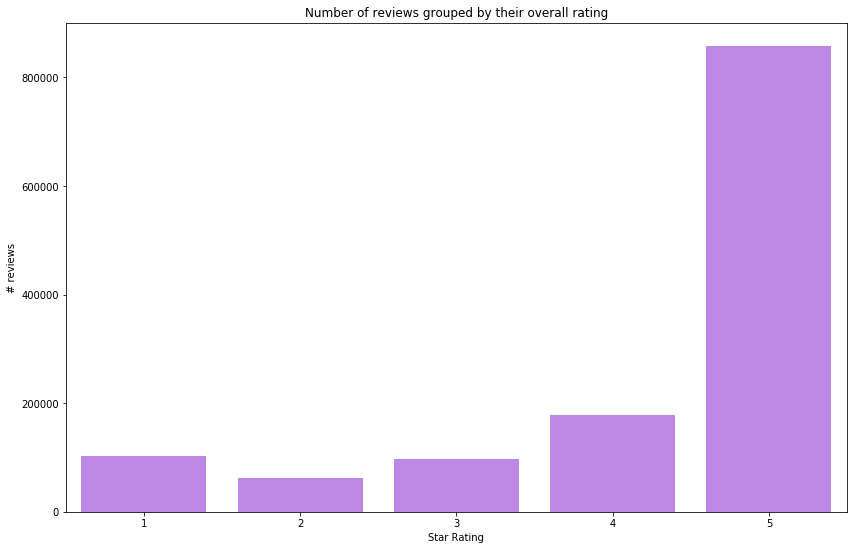

In [13]:
#Importing Seaborn and Matplotlib for graphical effects.
# Below we plot number of reviewers based on rating
import matplotlib.pyplot as plt
import seaborn as sns
light_purple = sns.xkcd_rgb["light purple"]
plt.figure(figsize=(14,9))
sns.countplot(x='overall', data=final_df, color=light_purple)
plt.xlabel('Star Rating')
plt.ylabel('# reviews')
plt.title('Number of reviews grouped by their overall rating')
plt.show()

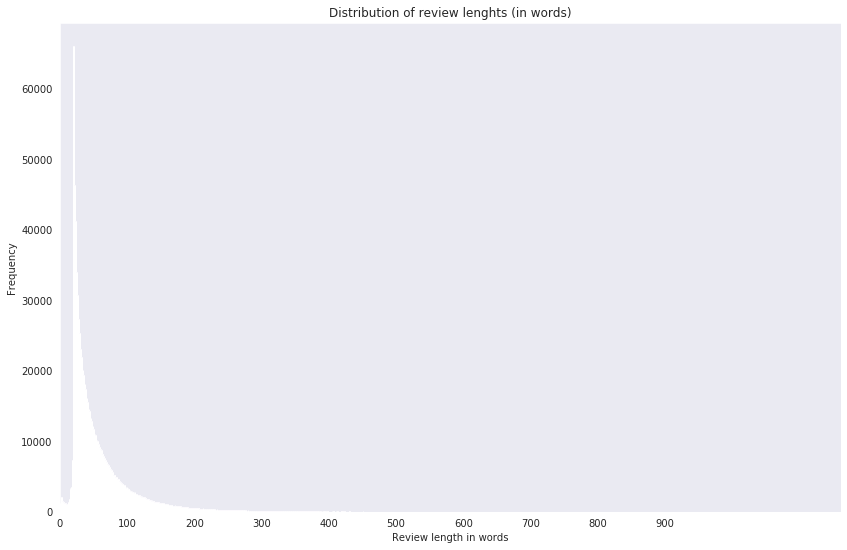

In [14]:
final_df["text_word_count"] = final_df["reviewText"].apply(lambda text: len(text.split()))
sns.set_style("dark")
plt.figure(figsize=(14,9))
sns.countplot(x='text_word_count', data=final_df, color=light_purple)
plt.xlabel('Review length in words')
plt.xticks(np.arange(0,1000,100),np.arange(0,1000,100))
plt.ylabel('Frequency')
plt.title('Distribution of review lenghts (in words)')
plt.show()

In [15]:
final_df["text_word_count"].describe()

count    1.297156e+06
mean     6.075384e+01
std      6.311986e+01
min      0.000000e+00
25%      2.600000e+01
50%      4.100000e+01
75%      7.200000e+01
max      4.693000e+03
Name: text_word_count, dtype: float64

In [16]:
final_df[final_df.overall==5].text_word_count.median()


38.0

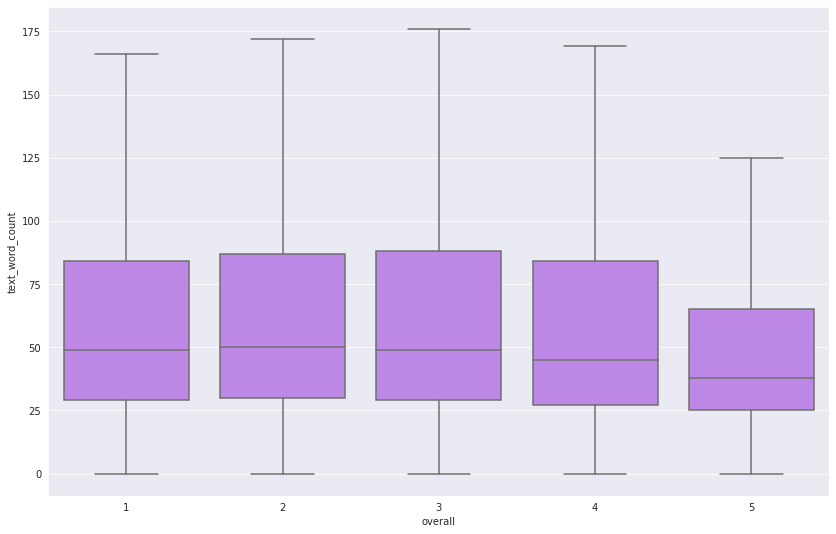

In [17]:
plt.figure(figsize=(14,9))
sns.set_style("dark")
sns.boxplot(x='overall',y='text_word_count', data=final_df, color=light_purple, showfliers=False)
plt.grid(axis="y")

## B.3 Frequency of reviewers


In [18]:

freq_user = final_df.reviewerID.value_counts()
freq_user.to_dict()
print("converted Series to dictionary")

converted Series to dictionary


In [19]:
final_df["reviewer_freq"] = final_df["reviewerID"].apply(lambda counts: "Frequent (>50 reviews)" \
                                                                 if freq_user[counts]>50 else "Not Frequent (1-50)")

## B.4 Are frequent reviewers more verbose?

The distributions of word counts for frequent and infrequent reviews shows that infrequent reviewers have a large amount of reviews of low word count. On the other hand, the largest concentration of word count is higher for frequent reviewers than for infrequent reviews. Moreover, the median word count for frequent reviewers is higher than the median for infrequent reviewers.

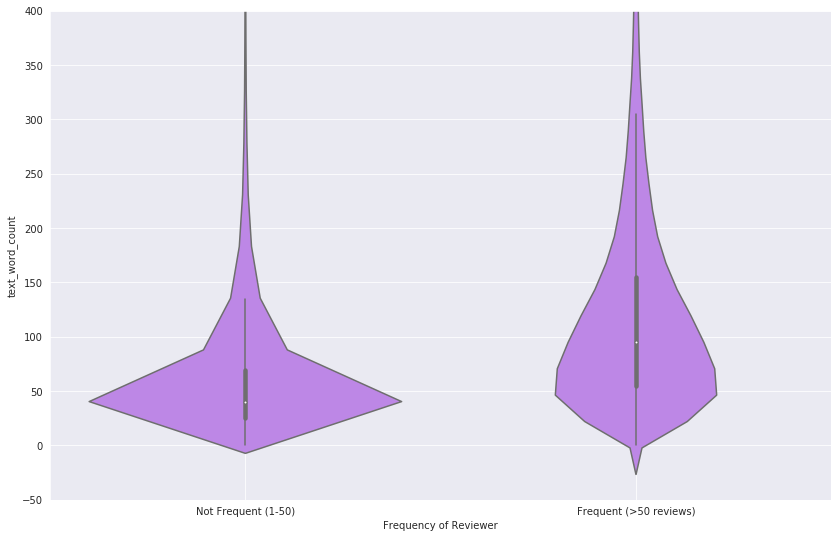

In [20]:
plt.figure(figsize=(14,9))

sns.violinplot(x='reviewer_freq', y='text_word_count',  \
               data=final_df, color=light_purple)
plt.xlabel('Frequency of Reviewer')
plt.ylim(-50, 400)
plt.grid("y")


## B.5 Review text Analysis

In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import gensim
import collections
from afinn import Afinn
%matplotlib inline






##Remove special characters from the review text
final_df['reviewText'] = final_df['reviewText'].str.replace("'", "")
final_df['reviewText'] = final_df['reviewText'].str.replace('[^a-zA-Z\s]',' ')




#Download stopwords and wordnet for lemmatization (only need to be executed once)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/embolo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/embolo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

stop_words = set(stopwords.words('english')) 

# Here we don't need stemming, because Afinn has same score for the before stemmed ones.
# stemmer = PorterStemmer()

def process_text(sentence):
    token_words = nltk.word_tokenize(sentence)
    no_stopwords = [word.lower() for word in token_words if word not in stop_words and not \
                    all(c in string.punctuation for c in word) and not len(word) < 2]
    # return [stemmer.stem(word) for word in no_stopwords]
    return [(word) for word in no_stopwords]

print(process_text('I ordered spongbob slippers and I got John'))

[nltk_data] Downloading package stopwords to /home/embolo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['ordered', 'spongbob', 'slippers', 'got', 'john']


In [23]:
stemmed = final_df.copy()
stemmed = stemmed[stemmed['overall'] < 3]
stemmed['reviewStemmed'] = stemmed['reviewText'].apply(lambda x : process_text(x))

stemmed.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,reviewStemmed
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,41,Not Frequent (1-50),"[ordered, spongbob, slippers, got, john, cena,..."
5,A3DTB6RVENLQ9Q,1453060375,Dont buy this item rip off at this price M...,1,2013-03-03,[[Grocery & Gourmet Food]],Mio,27,Not Frequent (1-50),"[dont, buy, item, rip, price, my, bad, mistake..."
46,A3KJ9TZ2HLL7SA,5901002482,I wrote an earlier scathing review of this pro...,1,2012-11-28,[[Grocery & Gourmet Food]],NaN,85,Not Frequent (1-50),"[wrote, earlier, scathing, review, product, wh..."
48,ACEL2LY99MAB0,6162362183,I read the reviews before I bought it It got ...,2,2014-04-21,[[Grocery & Gourmet Food]],Nestle,67,Not Frequent (1-50),"[read, reviews, bought, it, got, excited, revi..."
61,A2F3CK8F9VIFPL,616719923X,I bought it because i like green tea but the t...,1,2013-07-29,[[Grocery & Gourmet Food]],NaN,27,Not Frequent (1-50),"[bought, like, green, tea, taste, bad, came, m..."


In [24]:
def flatten(nested_list):
    return [e for inner_list in nested_list for e in inner_list]

In [25]:
l_stemmed = stemmed['reviewStemmed'].values.tolist()
l_stemmed = flatten(l_stemmed)

In [26]:
frequentWords = collections.Counter(l_stemmed).most_common()[0:50000]
frequentWords = [word for word, count in frequentWords]

In [27]:
len(frequentWords)
len(set(l_stemmed))
#len(l_stemmed)

75800


## B.6 Zipf's Law

Zipf's law is an empirical law formulated using mathematical statistics. The law is named after the linguist George Kingsley Zipf, who first proposed it

Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Another way to state Zipf's law is: small number of words are used all the time, while majority of words are used rarely

In [28]:
frequentWords = collections.Counter(l_stemmed).most_common()
df = pd.DataFrame(frequentWords, columns = ['FrequentWords' , 'Count']).set_index('FrequentWords')

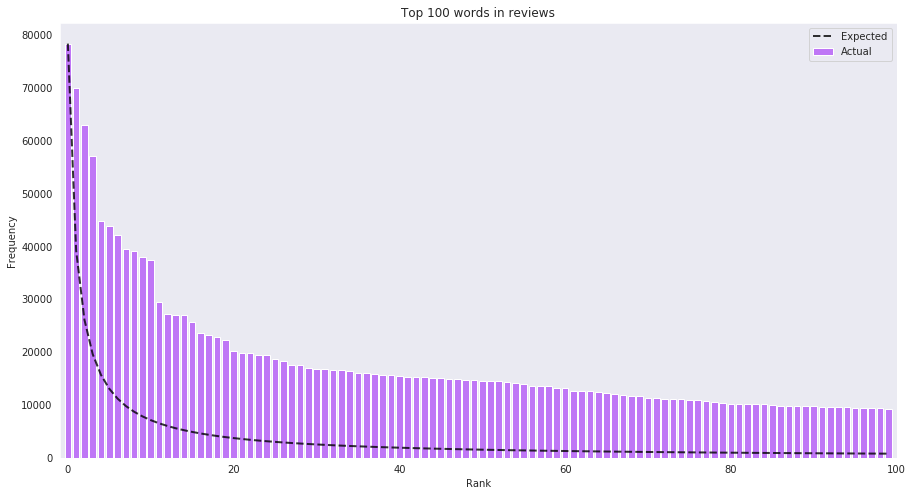

In [29]:
n_words = 100
x = np.arange(n_words)
y = df.iloc[:n_words, 0]
most_frequent_word = y[0]
expected_zipf = [most_frequent_word / (i + 1) for i in range(n_words)]

plt.figure(figsize=(15, 8))
plt.bar(x, y, alpha=1, color=light_purple)
plt.plot(x, expected_zipf, color='black', linestyle='--', linewidth=2, alpha=0.8)

plt.xlim([-1, n_words])
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Top {} words in reviews'.format(n_words))
plt.legend(['Expected', 'Actual'])



X axis is rank of frequency from highest rank from left up to 100th rank to the right.

Y axis is frequency of words in given corpus.

We can see that plot follows the trend of Zipf's law. Actual observations in most cases does not strictly follow Zipf’s distribution, but rather follow a trend of “near-Zipfian” distribution.


# C Labelling data

Using the Amazon dataset, our goal is to detect any potential harmful products by analyzing the user reviews and classifying them as presenting or not a possible health threat. Unfortunately, we lack the annotated data that would be needed to build a classifier.

We will thus create our own annotated data by using **empath** ,**affin** and  **fda recall reason text** . **Empath** is a python library that can be used to analyze documents over a set of predefined categories, and even generate new categories. **Affin** is a python library which gives the ability to append and overwrite word / value pairs from the AFINN wordlist  rated for valence with an integer between minus five (negative) and plus five (positive). Sentiment analysis is performed by cross-checking the string tokens (words, emojis) with the AFINN list and getting their respective scores. **FDA recall** we use two fda datasets: Fda enforcement and fda press release, using which we build a list of words (library) by parsing fda recall reason text.

We start by importing the affin library.

## C.1 Labeling the amazon reviews with empath sentiment analysis.

Empath is a tool for analyzing text across lexical categories (similar to LIWC), and also generating new lexical categories to use for an analysis. Empath draws connotations between words and phrases by deep learning a neural embedding across more than 1.8 billion words of modern fiction. Given a small set of seed words that characterize a category, Empath uses its neural embedding to discover new related terms, then validates the category with a crowd-powered filter. Empath also analyzes text across 200 built-in, pre-validated categories we have generated from common topics in our web dataset, like neglect, government, and social media.



In [30]:
from empath import Empath

We then create a new lexical category **healthConcerns** as a combination of the seeds words **health**, **danger** and **food poisoning**.

In [31]:
lexicon = Empath()

lexicon.create_category('healthConcerns', \
                        seeds=['health', 'danger', 'food poisoning'])


["health", "danger", "welfare", "human_life", "illness", "sickness", "necessity", "safety", "responsibility", "mental_state", "dangers", "well-being", "risk", "lifemate", "knowledge", "survival", "consequence", "humanity", "recovery", "exposure", "risks", "capacity", "wellbeing", "peril", "potential", "responsibilities", "downfall", "death", "loyalty", "bloodline", "fear", "judgement", "poverty", "responsible", "threat", "condition", "importance", "treatment", "current_state", "disease", "discipline", "top_priority", "judgment", "affairs", "healing", "cruelty", "human_race", "sacrifice", "ensure", "demise", "hardship", "separation", "vital", "healer", "losses", "likelihood", "environment", "Psy", "hazard", "corruption", "independence", "future", "own_safety", "needs", "killing", "normalcy", "Council", "suffering", "stability", "virtue", "disability", "sacrifices", "conditions", "free_will", "failure", "therefore", "carelessness", "involvement", "mindset", "unborn_child", "relations", "

In [32]:
def analyze(x):
    ret = lexicon.analyze(x, categories=["healthConcerns"])
    if (ret == None):
        return 0.0
    else:
        return ret.get('healthConcerns')

We now create a new column do our dataframe, obtained by analyzing the reviews and assigning them a score. The higher the score is, the more that review exposes possible health concerns. 

In [33]:
empathy = final_df.copy()
empathy['healthScore'] = empathy['reviewText'].apply(lambda x : analyze(x))

empathy.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,5,2013-10-11,[[Grocery & Gourmet Food]],NaN,88,Not Frequent (1-50),0.0
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,5,2012-12-06,[[Grocery & Gourmet Food]],NaN,119,Not Frequent (1-50),0.0
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,41,Not Frequent (1-50),0.0
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,2011-06-12,[[Grocery & Gourmet Food]],NaN,60,Not Frequent (1-50),0.0
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,2012-03-24,[[Grocery & Gourmet Food]],NaN,66,Not Frequent (1-50),0.0


Now that all our reviews have been assign a score, let's have a look at its distribution.

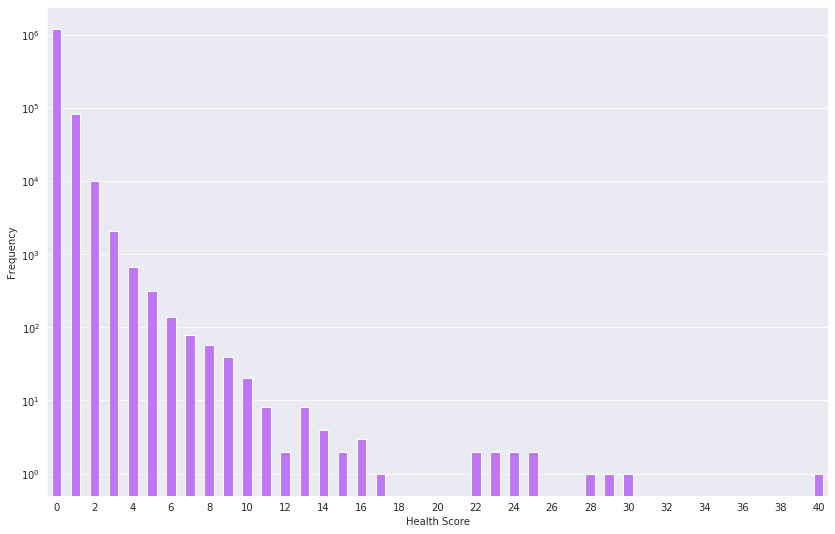

In [34]:
plt.figure(figsize=(14,9))
empathy.groupby(by='healthScore') \
        .count()['reviewText'] \
        .reindex(list(range(41))) \
        .fillna(0) \
        .plot.bar(rot=0, color=light_purple, log=True)
plt.xticks(range(0,41,2),range(0,41,2))
plt.xlabel("Health Score")
plt.ylabel("Frequency")
plt.grid(axis="y")

As expected, we observe that a vast majority of the reviews don't expose any kind of health-related issues (symbolized by the pic at x = 0). Let's dive deeper and have a closer look at the reviews with a score bigger than 0.

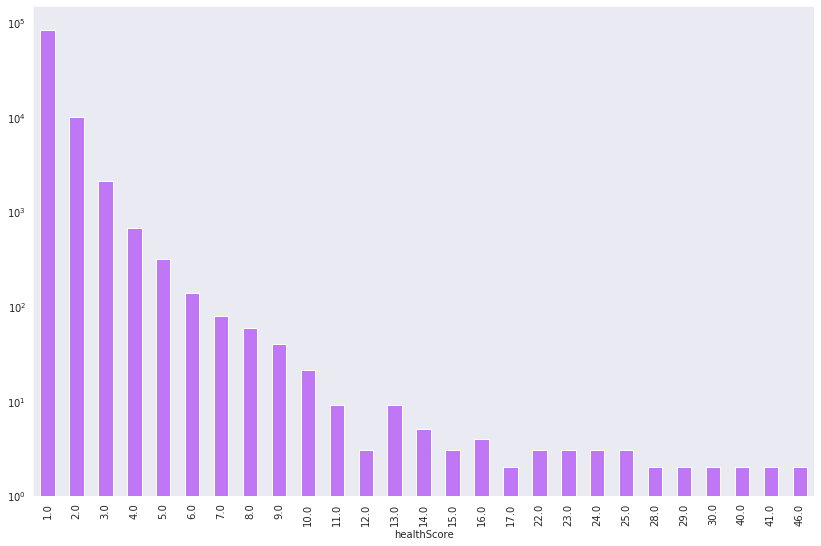

In [35]:
plt.figure(figsize=(14,9))
empathyScore = empathy[empathy['healthScore'] > 0]

empathyScore.groupby(by='healthScore').count()['reviewText'].plot.bar(color=light_purple, log=True)
# the following plot is not needed anymore as the previous one contains the same information

Text(0.5, 1.0, 'Health Score per overall Rating')

<Figure size 1296x648 with 0 Axes>

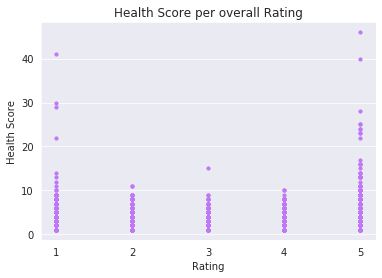

In [36]:
plt.figure(figsize=(18,9))
empathyScore.plot.scatter('overall', 'healthScore', s=10,c=light_purple)
plt.xticks(range(1,6,1),range(1,6,1))
plt.xlabel("Rating")
plt.ylabel("Health Score")
plt.grid(axis="y")
plt.title("Health Score per overall Rating")

We observe here something pretty unexpected : most of the reviews with a high healthScore have an associated rating of 3 or more, with the highest healthScore at x=5. A fair assumption would be that a reviewer exposed to health issues due to a product would attribute it a low score, which is not the case here. Let's have a look at the reviews themselves now, to gain more insights.

In [37]:
empathyScore[empathyScore['overall'] == 5].sort_values(by='healthScore', ascending=False).head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore
632161,A1FLQ698D9C0C8,B002P0Q14C,Tea Antioxidants Antioxidants c...,5,2009-09-13,[[Grocery & Gourmet Food]],NaN,1976,Not Frequent (1-50),46.0
388784,A1J7FP5XCCSHSM,B001AG6BMO,Uses for Coconut Oil Coconut Oil Is Anti b...,5,2012-03-22,"[[Grocery & Gourmet Food, Cooking & Baking, Co...",Garden of Life,4693,Not Frequent (1-50),40.0
428754,A3RR2P5IS3DGPR,B001E5E2MC,I love each of my Beef Pork Lamb Fish and t...,5,2010-04-24,[[Grocery & Gourmet Food]],NaN,2351,Frequent (>50 reviews),28.0
286194,A356RFKNIG043B,B000R71WMQ,I cant begin to praise apple cider vinegar ac...,5,2014-04-05,[[Grocery & Gourmet Food]],Bragg,1394,Not Frequent (1-50),25.0
1243839,AUYT2H281GPNJ,B00DS842HS,Well the wife and I have been using coconut o...,5,2013-10-02,[[Grocery & Gourmet Food]],Viva Labs,1379,Not Frequent (1-50),25.0


In [38]:
[x[:1000] for x in empathyScore[empathyScore['overall'] == 5] \
 .sort_values(by='healthScore', ascending=False) \
 .reviewText.values[:2]]

['Tea Antioxidants                Antioxidants can help the body protect itself against free radicals  molecules that can damage cells  Antioxidants in tea called flavonoids can do that Whether iced or hot  Teas made from real tea leaves provide more than great taste  Like fruits and vegetables  regular and decaffeinated brewed teas contain natural antioxidants called flavonoids                   Research suggests that antioxidants can be beneficial to health by helping the body protect itself from the harmful effects of  free radicals                       Free radicals  molecules which occur in the environment and are naturally produced by the body  can cause damage to cells  Chronic damage by free radicals is one factor thought to contribute to the development of many chronic diseases including heart disease or cancer  An average cup of brewed green or black tea has         mg of flavonoids         Currently  teas potential health benefits are the focus of many scientific studies  a

As we see with those reviews, there seems to be something off with them (note that, for readability purposes, we only show the first thousand characters of those reviews) : they look more like some ad of the product's benefits/usages than actual reviews. Our initial assumption seems thus accurate : even though those "reviews" are health-related, they are not what we are looking for. We are thus going to ignore them. Let's continue our analysis with the reviews with score 3 and 4.

In [39]:
[x[:1000] for x in \
 empathyScore[empathyScore['overall'] == 4] \
 .sort_values(by='healthScore', ascending=False) \
 .reviewText.values[:3]]

['I am always looking for an alternative sweetener to get away from fructose  Most of the artificial sweeteners on the market are terrible for your health   I will name splenda as one of the worse  Stevia is made directly from the dried leaves of the Stevia plant so that is acceptable  but I find it kind of bitter and it is very expensive  You can google  xylitol benefits  and get all kinds of interesting information  but I will just reiterate some of the very interesting benefits I found when googling Xylitol is a natural sugar alcohol that has been recognized by dentists and health professionals worldwide as a great alternative to white sugar Commonly found in chewing gum and breathmints  Xylitol is known to have a many health benefits associated with its use    Safe For DiabeticsUnlike sugar  xylitol is not easily converted to fat  Because it is not easily converted to fat  it has almost no effect on insulin levels  making it a safe sugar alternative for diabetics  body builders  di

In [40]:
[x[:1000] for x in \
 empathyScore[empathyScore['overall'] == 3] \
 .sort_values(by='healthScore', ascending=False) \
 .reviewText.values[:3]]

['Yerba Mate  like caffeine  is a stimulant   Both increase heart rate  blood pressure and impact various metabolic processes that work cooperatively to maintain homeostasis within your body   In moderate amounts each can be tolerated without incident in well adults  Yerba Mate compounds are not likely to pose a risk for healthy well adults who occasionally drink it However  some studies indicate that  certain people who drink large amounts of yerba mate over prolonged periods may be at increased risk of certain types of cancer  such as cancer of the mouth  esophagus and lungs  Those with Thyroid or auto immune conditions are at greater risk for developing thyroid goiters  cancers and lymphatic cancers   Smoking  drinking or prolonged high blood sugar in combination with yerba mate seems to greatly increase serious health risks such as cancer One possible explanation is that mate contains polycyclic aromatic hydrocarbons  PAHs   which are known to be carcinogenic   Tobacco smoke and gr

We see that reviews with a 4 score don't really assert the reviewed product's health issues, but its competitors or other aspects. Whereas the reviews rated 3-stars seem to correspond to what we were looking for.

Thus, for our labelled data, we're going to limit ourselves to the reviews with a healthScore strictly positive, and with a rating smaller or equal to 3.

In [41]:
empathy['danger'] = np.where(np.logical_and(empathy['healthScore'] > 0., empathy['overall'] < 4), \
                             1, np.nan)


empathy.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore,danger
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,5,2013-10-11,[[Grocery & Gourmet Food]],NaN,88,Not Frequent (1-50),0.0,NaN
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,5,2012-12-06,[[Grocery & Gourmet Food]],NaN,119,Not Frequent (1-50),0.0,NaN
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,41,Not Frequent (1-50),0.0,NaN
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,2011-06-12,[[Grocery & Gourmet Food]],NaN,60,Not Frequent (1-50),0.0,NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,2012-03-24,[[Grocery & Gourmet Food]],NaN,66,Not Frequent (1-50),0.0,NaN


In [42]:
print("Number of reviews that we will use as positive labelled data : {}" \
      .format(len(empathy[empathy['danger'] == 1])))

Number of reviews that we will use as positive labelled data : 20253


For the negative examples (i.e. the reviews that don't present any health danger), we are simply going to select a random sample of the reviews with a health score of 0.

In [43]:
negative_sample = empathy[empathy['danger'].isna()].sample(frac=0.1, random_state=10)

print("Size of the sample : {}".format(len(negative_sample)))

negative_sample.head()

Size of the sample : 127690


,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore,danger
773815,A1XNL8W3QR35SV,B0042RNHVG,My family really loves this stuff Excellent p...,5,2013-04-10,[[Grocery & Gourmet Food]],NaN,20,Not Frequent (1-50),0.0,NaN
841465,ASDUAGZMZ7W8J,B004I1H1H2,They arrived in a timely manner and were extre...,5,2014-05-13,[[Grocery & Gourmet Food]],NaN,28,Not Frequent (1-50),0.0,NaN
1115952,A4ANM0GLEMU1S,B008P0BG7I,Just started using this very nice coconut oil...,5,2014-02-21,[[Grocery & Gourmet Food]],Carrington Farms,27,Not Frequent (1-50),0.0,NaN
82265,A39TW2C1KMB1QC,B000BXSRT2,Yum Yum Yum They taste as good as they did i...,5,2012-04-12,[[Grocery & Gourmet Food]],Candy Crate,31,Not Frequent (1-50),0.0,NaN
378003,A2XNOB1T796Y6B,B0017ZBT6Q,I had the pleasure of trying these for the fir...,4,2013-05-30,[[Grocery & Gourmet Food]],Knott&#39;s,252,Frequent (>50 reviews),0.0,NaN


Now that we have our negative sample, let's update our original dataframe : we are going to associate the label 0 to the sampled reviews

In [44]:
empathy['danger'] = np.where(empathy['reviewText'].isin(negative_sample['reviewText']), \
                            0, empathy['danger'])

empathy.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore,danger
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,5,2013-10-11,[[Grocery & Gourmet Food]],NaN,88,Not Frequent (1-50),0.0,0.0
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,5,2012-12-06,[[Grocery & Gourmet Food]],NaN,119,Not Frequent (1-50),0.0,NaN
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,41,Not Frequent (1-50),0.0,NaN
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,2011-06-12,[[Grocery & Gourmet Food]],NaN,60,Not Frequent (1-50),0.0,0.0
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,2012-03-24,[[Grocery & Gourmet Food]],NaN,66,Not Frequent (1-50),0.0,NaN


Let's ensure that it indeed worked :

In [45]:
print("""Number of reviews that we will use as positive labelled data : {},
       and as negative samples : {}"""
      .format(len(empathy[empathy['danger'] == 1]), len(empathy[empathy['danger'] == 0])))

Number of reviews that we will use as positive labelled data : 20253,
       and as negative samples : 129150


In [46]:
empathy.to_pickle('empath')

## C.2 Labeling the amazon reviews with Afinn sentiment analysis.

In [47]:
afinn = Afinn()

# Compute affin score for all the stemmed words
stemmed['afinnWords'] = stemmed['reviewText'].apply(lambda x : afinn.find_all(x))
stemmed['afinnScores'] = stemmed['reviewText'].apply(lambda x : afinn.scores_with_pattern(x))
stemmed['afinnTotalScore'] = stemmed['reviewText'].apply(lambda x : afinn.score_with_pattern(x))
stemmed['afinnWordsLen'] = stemmed['afinnWords'].apply(lambda x : len(x))

In [48]:
stemmed['afinnMeanScore'] = (stemmed['afinnTotalScore']/stemmed['afinnWordsLen']).round()

In [49]:
stemmed.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,reviewStemmed,afinnWords,afinnScores,afinnTotalScore,afinnWordsLen,afinnMeanScore
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,41,Not Frequent (1-50),"[ordered, spongbob, slippers, got, john, cena,...",[happy],[3],3.0,1,3.0
5,A3DTB6RVENLQ9Q,1453060375,Dont buy this item rip off at this price M...,1,2013-03-03,[[Grocery & Gourmet Food]],Mio,27,Not Frequent (1-50),"[dont, buy, item, rip, price, my, bad, mistake...","[bad, mistake, pay, pay]","[-3, -2, -1, -1]",-7.0,4,-2.0
46,A3KJ9TZ2HLL7SA,5901002482,I wrote an earlier scathing review of this pro...,1,2012-11-28,[[Grocery & Gourmet Food]],NaN,85,Not Frequent (1-50),"[wrote, earlier, scathing, review, product, wh...","[harsh, apologize, disappointed, protect, hope...","[-2, -1, -2, 1, 2, -2]",-4.0,6,-1.0
48,ACEL2LY99MAB0,6162362183,I read the reviews before I bought it It got ...,2,2014-04-21,[[Grocery & Gourmet Food]],Nestle,67,Not Frequent (1-50),"[read, reviews, bought, it, got, excited, revi...","[excited, good, destroyed, mad, disappointed, ...","[3, 3, -3, -3, -2, 3]",1.0,6,0.0
61,A2F3CK8F9VIFPL,616719923X,I bought it because i like green tea but the t...,1,2013-07-29,[[Grocery & Gourmet Food]],NaN,27,Not Frequent (1-50),"[bought, like, green, tea, taste, bad, came, m...","[like, bad]","[2, -3]",-1.0,2,-0.0


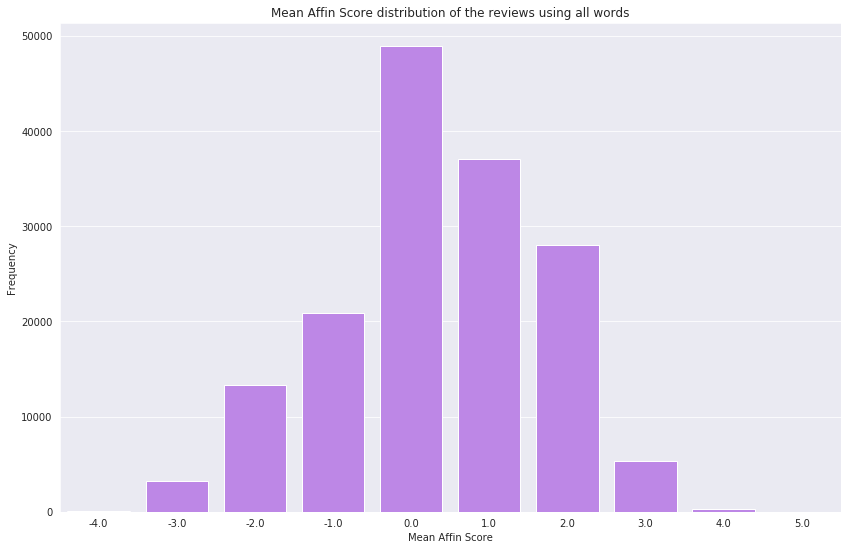

In [50]:
plt.figure(figsize=(14,9))
sns.countplot(x='afinnMeanScore', data=stemmed, color=light_purple)
plt.xlabel('Mean Affin Score')
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.title("Mean Affin Score distribution of the reviews using all words")
plt.show()

In [51]:
# With using wordcloud library, make a function visualizes the words in these two lists
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(14, 9))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.5)

    plt.imshow(wordcloud)
    plt.show()

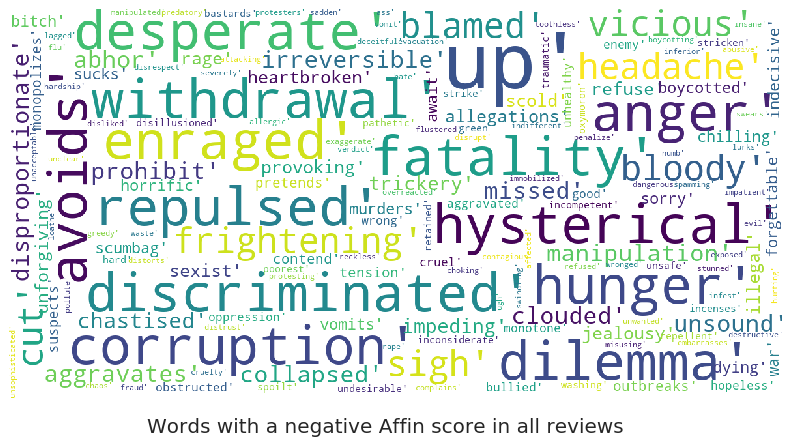

In [52]:
l_words = stemmed['afinnWords'].values.tolist()
l_words = flatten(l_words)
l_scores = stemmed['afinnScores'].values.tolist()
l_scores = flatten(l_scores)
words_scores = list(zip(l_words, l_scores))
negative_scores = set([word for word, score in words_scores if score<0])
show_wordcloud(negative_scores, title = "Words with a negative Affin score in all reviews")


In [53]:
# Compute affin score for all the frequent stemmed words

frequentWords = [word for word, count in frequentWords]

stemmed_frequent = stemmed.copy()
stemmed_frequent['afinnWords'] = stemmed['afinnWords'].apply(lambda x : [i for i in x if i in frequentWords])
stemmed_frequent['afinnScores'] = stemmed_frequent['reviewText'].apply(lambda x : afinn.scores_with_pattern(x))
stemmed_frequent['afinnTotalScore'] = stemmed_frequent['reviewText'].apply(lambda x : afinn.score_with_pattern(x))
stemmed_frequent['afinnWordsLen'] = stemmed_frequent['afinnWords'].apply(lambda x : len(x))

In [54]:
stemmed_frequent['afinnMeanScore'] = (stemmed_frequent['afinnTotalScore']/stemmed_frequent['afinnWordsLen']).round()

In [55]:
stemmed_frequent.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,reviewStemmed,afinnWords,afinnScores,afinnTotalScore,afinnWordsLen,afinnMeanScore
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,41,Not Frequent (1-50),"[ordered, spongbob, slippers, got, john, cena,...",[happy],[3],3.0,1,3.0
5,A3DTB6RVENLQ9Q,1453060375,Dont buy this item rip off at this price M...,1,2013-03-03,[[Grocery & Gourmet Food]],Mio,27,Not Frequent (1-50),"[dont, buy, item, rip, price, my, bad, mistake...","[bad, mistake, pay, pay]","[-3, -2, -1, -1]",-7.0,4,-2.0
46,A3KJ9TZ2HLL7SA,5901002482,I wrote an earlier scathing review of this pro...,1,2012-11-28,[[Grocery & Gourmet Food]],NaN,85,Not Frequent (1-50),"[wrote, earlier, scathing, review, product, wh...","[harsh, apologize, disappointed, protect, hope...","[-2, -1, -2, 1, 2, -2]",-4.0,6,-1.0
48,ACEL2LY99MAB0,6162362183,I read the reviews before I bought it It got ...,2,2014-04-21,[[Grocery & Gourmet Food]],Nestle,67,Not Frequent (1-50),"[read, reviews, bought, it, got, excited, revi...","[excited, good, destroyed, mad, disappointed, ...","[3, 3, -3, -3, -2, 3]",1.0,6,0.0
61,A2F3CK8F9VIFPL,616719923X,I bought it because i like green tea but the t...,1,2013-07-29,[[Grocery & Gourmet Food]],NaN,27,Not Frequent (1-50),"[bought, like, green, tea, taste, bad, came, m...","[like, bad]","[2, -3]",-1.0,2,-0.0


In [56]:
stemmed_frequent['afinnMeanScore']= stemmed_frequent['afinnMeanScore'].replace([np.inf, -np.inf], np.nan)

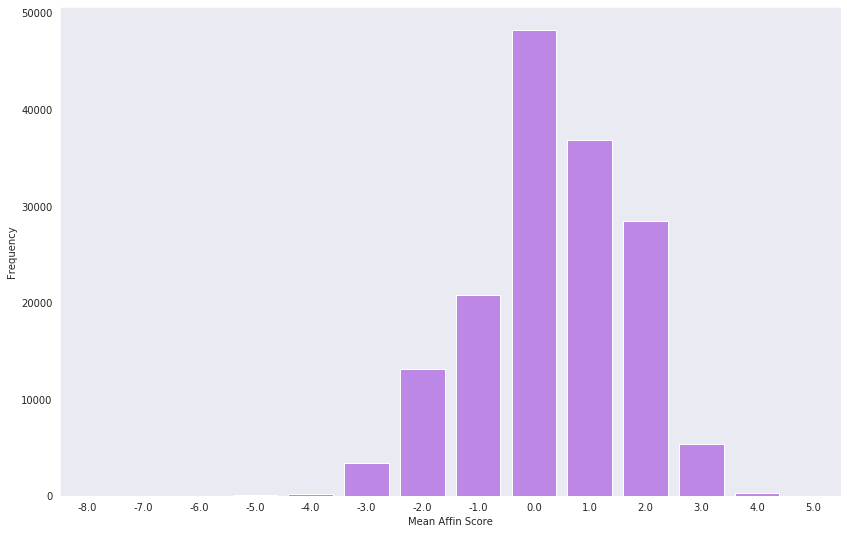

In [57]:
plt.figure(figsize=(14,9))
sns.countplot(x='afinnMeanScore', data=stemmed_frequent, color=light_purple)
plt.xlabel('Mean Affin Score')
plt.ylabel('Frequency')
plt.show()

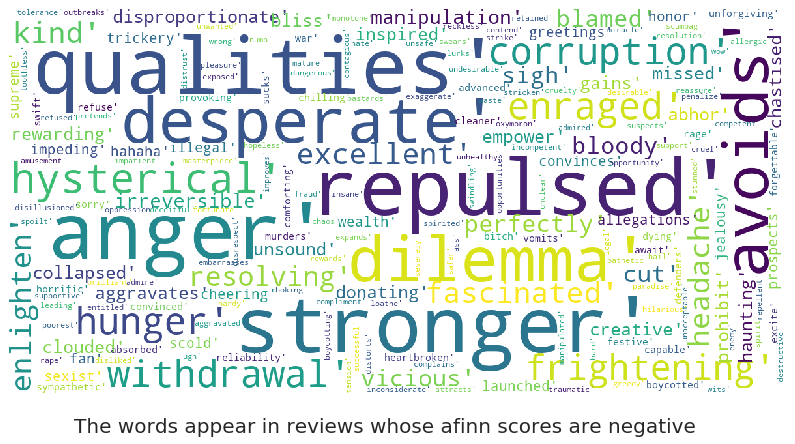

In [58]:
l_words = stemmed_frequent['afinnWords'].values.tolist()
l_words = flatten(l_words)
l_scores = stemmed_frequent['afinnScores'].values.tolist()
l_scores = flatten(l_scores)
words_scores = list(zip(l_words, l_scores))
negative_scores = set([word for word, score in words_scores if score<0])
show_wordcloud(negative_scores, title = "The words appear in reviews whose afinn scores are negative")


In [59]:
stemmed_frequent.groupby(by=['afinnWordsLen']).describe()

overall                                               \
                 count      mean       std  min  25%  50%  75%  max   
afinnWordsLen                                                         
0               7686.0  1.351288  0.477404  1.0  1.0  1.0  2.0  2.0   
1              20039.0  1.384201  0.486418  1.0  1.0  1.0  2.0  2.0   
2              26518.0  1.386982  0.487069  1.0  1.0  1.0  2.0  2.0   
3              25536.0  1.381070  0.485659  1.0  1.0  1.0  2.0  2.0   
4              20402.0  1.374228  0.483935  1.0  1.0  1.0  2.0  2.0   
...                ...       ...       ...  ...  ...  ...  ...  ...   
139                1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
143                1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
177                1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
200                1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
249                1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0   

              text_word_count               ... afinnTotalScore         \
                        count         mean  ...             75%    max   
afinnWordsLen                               ...                          
0                      7686.0    28.940932  ...             0.0    0.0   
1                     20039.0    32.536154  ...             2.0    5.0   
2                     26518.0    37.344257  ...             4.0    9.0   
3                     25536.0    44.513197  ...             4.0   12.0   
4                     20402.0    54.396138  ...             5.0   14.0   
...                       ...          ...  ...             ...    ...   
139                       1.0  1939.000000  ...           -32.0  -32.0   
143                       1.0  2400.000000  ...            64.0   64.0   
177                       1.0  2537.000000  ...           -16.0  -16.0   
200                       1.0  2913.000000  ...            46.0   46.0   
249                       1.0  3368.000000  ...           383.0  383.0   

              afinnMeanScore                                               
                       count      mean       std  min  25%  50%  75%  max  
afinnWordsLen                                                              
0                        0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN  
1                    20039.0  0.306502  2.197816 -8.0 -2.0  1.0  2.0  5.0  
2                    26518.0  0.295988  1.538163 -5.0  0.0  0.0  2.0  4.0  
3                    25536.0  0.328987  1.338048 -4.0 -1.0  0.0  1.0  4.0  
4                    20402.0  0.334085  1.190062 -4.0  0.0  0.0  1.0  4.0  
...                      ...       ...       ...  ...  ...  ...  ...  ...  
139                      1.0  0.000000       NaN -0.0 -0.0 -0.0 -0.0 -0.0  
143                      1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0  
177                      1.0  0.000000       NaN -0.0 -0.0 -0.0 -0.0 -0.0  
200                      1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0  
249                      1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0  

[92 rows x 32 columns]

## C.3 Labeling the amazon reviews with FDA Recall data sets.

We worked on creating a NLP model to detect reviews about health issues from Amazon reviews. Here, we create verify data to confirm whether the detected results are really related to health problems and whether there are any omissions.
FDA (The Food and Drug Administration) is responsible for protecting the public health by ensuring the safety, efficacy, and security of human and veterinary drugs, biological products, and medical devices; and by ensuring the safety of our nation's food supply, cosmetics, and products that emit radiation. A recall is a method of removing or correcting products that are in violation of laws administered by the FDA.
Here, we have data on foods that have been recalled by the FDA in the past, together with recall reason statements. By extracting a word that has been referred to a plurality of times from among the words described in the recall reasoning sentence, it is possible to detect a word related to health in a review about food.

In [60]:
df_press_released = pd.read_csv(path_press_released)
df_enforced = pd.read_csv(path_enforced, encoding = 'unicode_escape')

In [61]:
stemmed_press_released = df_press_released.copy()
stemmed_press_released['stemmed_Reason'] = stemmed_press_released['Reason'].astype(str).apply(lambda x : process_text(x))
stemmed_enforced = df_enforced.copy()
stemmed_enforced['stemmed_Reason.for.Recall'] = stemmed_enforced['Reason.for.Recall'].astype(str).apply(lambda x : process_text(x))

In [62]:
stemmed_press_released.head()

,Unnamed: 0,Date,Brand,ProductDescription,Reason,Company,Url,stemmed_Reason
0,0,"Sat, 31 Dec 2011 22:37:00 -0500","Let&#39;s Grow Healthy Together!, Green Valley...",Sprouts,Listeria monocytogenes,Green Valley Food Corp.,http://wayback.archive-it.org/7993/20170406200...,"[listeria, monocytogenes]"
1,1,"Sat, 31 Dec 2011 00:00:00 -0500",Edelweiss Creamery,cheese,Listeria monocytogenes,Alpine Slicing and Cheese Conversion,http://wayback.archive-it.org/7993/20170406200...,"[listeria, monocytogenes]"
2,2,"Sat, 31 Dec 2011 00:00:00 -0500",Brennan&#39;s Cellars,Cheese,Listeria monocytogenes,Alpine Slicing and Cheese Conversion,http://wayback.archive-it.org/7993/20170406200...,"[listeria, monocytogenes]"
3,3,"Fri, 30 Dec 2011 00:00:00 -0500",Martinelli&#39;s Gold Medal,Sparkling Cider,Defective Seal,S. Martinelli &amp; Company,http://wayback.archive-it.org/7993/20170406200...,"[defective, seal]"
4,4,"Fri, 30 Dec 2011 00:00:00 -0500",Organique by Himalaya,Night Cream,staphylococcus aureus and fungus,HimalayaUSA,http://wayback.archive-it.org/7993/20170406200...,"[staphylococcus, aureus, fungus]"


In [63]:
stemmed_enforced.head()

,Product.Type,Recently.Updated.Record,Last.Modified.Date,Event.ID,Status,Recalling.Firm,Address1,Address2,City,State.Province,...,Product.Description,Product.Quantity,Reason.for.Recall,Recall.Initiation.Date,Center.Classification.Date,Termination.Date,Report.Date,Code.Info,More.Code.Info,stemmed_Reason.for.Recall
0,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Macaroni Reg CAD, Formula MA.50, Macaroni Sal...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by dates: 10/21/13-12/11/13.,NaN,"[the, recalled, products, potentially, contami..."
1,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Reser's Fine Foods, Cheesy Macaroni Salad, For...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/20/13 and 12/01/13.,NaN,"[the, recalled, products, potentially, contami..."
2,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Reser's Fine Foods, Potato Salad, Formula PO.9...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/23/13-12/09/13.,NaN,"[the, recalled, products, potentially, contami..."
3,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Potato Salad with Egg, Formula PO.71, packaged...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/20/13 - 12/12/13.,NaN,"[the, recalled, products, potentially, contami..."
4,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,"Potato Salad with Deviled Egg, Formula PO.16, ...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/13/2013 - 11/15/13.,NaN,"[the, recalled, products, potentially, contami..."


In [64]:
# Make lists of reason sentences in the press released dataset and the enforced dataset

l_stemmed_press_released = stemmed_press_released['stemmed_Reason'].values.tolist()
l_stemmed_press_released = flatten(l_stemmed_press_released)

l_stemmed_enforced = stemmed_enforced['stemmed_Reason.for.Recall'].values.tolist()
l_stemmed_enforced = flatten(l_stemmed_enforced)

In [65]:
# Count how many times each word appears in these words lists.
# Remove words that have less than two characters.

press_released_sorted = collections.Counter(l_stemmed_press_released).most_common()
enforced_sorted = collections.Counter(l_stemmed_enforced).most_common()

# Sort these two lists by count
words_press_released_sorted = [word for word, count in press_released_sorted if len(word)>2]
words_enforced_sorted = [word for word, count in enforced_sorted if len(word)>2]

In [66]:
# With using wordcloud library, make a function visualizes the words in these two lists
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(14, 9))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.5)

    plt.imshow(wordcloud)
    plt.show()

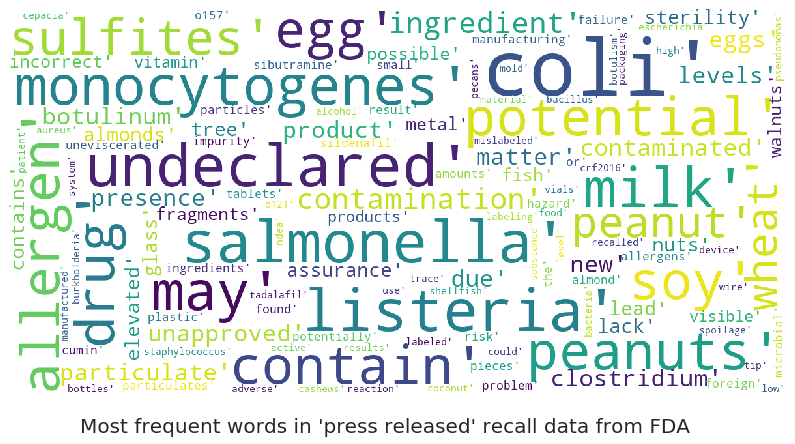

In [67]:
# Visualize the top 200 frequent words in the press released reason sentenses
show_wordcloud(words_press_released_sorted[:200], title = "Most frequent words in 'press released' recall data from FDA")

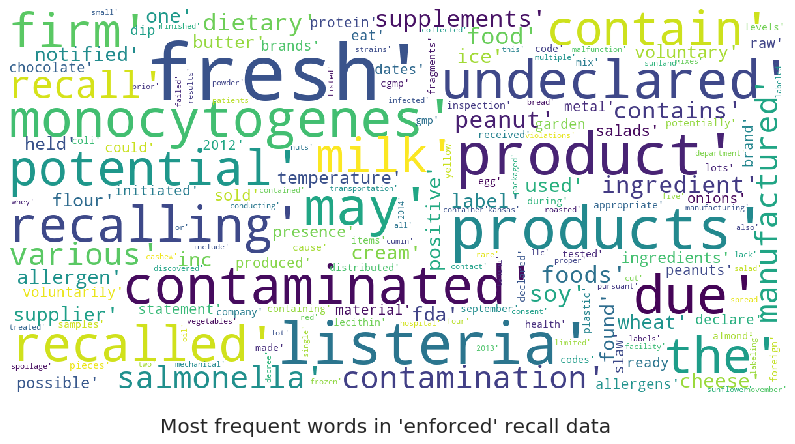

In [68]:
# Visualize the top 200 frequent words in the enforced reason sentenses
show_wordcloud(words_enforced_sorted[:200], title = "Most frequent words in 'enforced' recall data")

Here, we got words lists from both the press released dataset and the enforced dataset. We can see that these words strongly connect to health problems.  
Then, in these lists, there might be some usuless words that appear few times. Let's check these words and delete them.

In [69]:
# Count all of the words in each list
counts_press_released = pd.Series([count for word, count in press_released_sorted if len(word)>2])
counts_enforced = pd.Series([count for word, count in enforced_sorted if len(word)>2])

Text(0.5, 1.0, 'Histogram of counts of words appear in the enforced dataset')

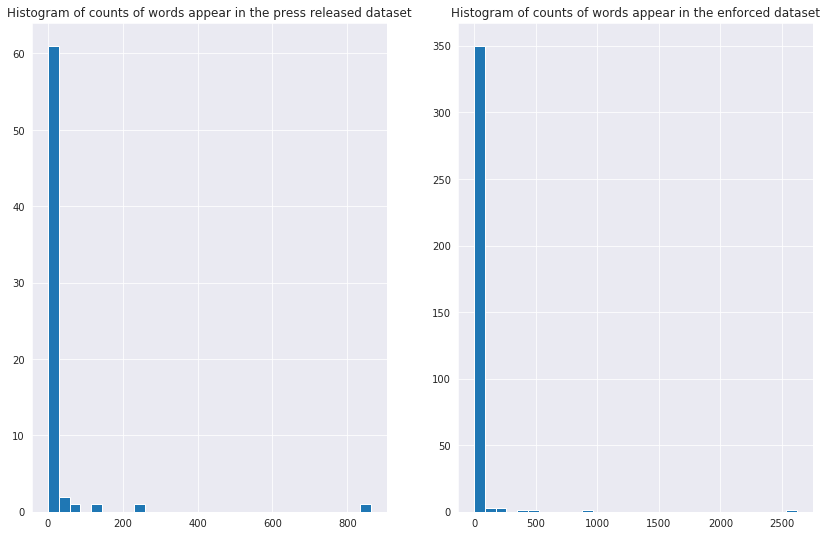

In [70]:
# Plot the histograms of word counts in each list
plt.figure(figsize=(14, 9))

plt.subplot(1,2,1)
counts_press_released.value_counts().hist(bins=30)
plt.title("Histogram of counts of words appear in the press released dataset")

plt.subplot(1,2,2)
counts_enforced.value_counts().hist(bins=30)
plt.title("Histogram of counts of words appear in the enforced dataset")

In [71]:
print("The ratio of words that appear only once in words_press_released_sorted is {:.1f}%".format(counts_press_released.value_counts()[1]/len(words_press_released_sorted)*100))
print("The ratio of words that appear only once in words_enforced_sorted is {:.1f}%".format(counts_enforced.value_counts()[1]/len(words_enforced_sorted)*100))

The ratio of words that appear only once in words_press_released_sorted is 55.6%
The ratio of words that appear only once in words_enforced_sorted is 36.3%


In [72]:
# Let's see inside the press released  word list with specified word count 2 & 3
words_press_released_3 = [word for word, count in press_released_sorted if count==3 if len(word)>2]
words_press_released_4 = [word for word, count in press_released_sorted if count==4 if len(word)>2]

In [73]:
# Let's see inside the enforced word list with specified word count 5 & 10
words_enforced_5 = [word for word, count in enforced_sorted if count==5 if len(word)>2]
words_enforced_10 = [word for word, count in enforced_sorted if count==10 if len(word)>2]
words_enforced_15 = [word for word, count in enforced_sorted if count==15 if len(word)>2]

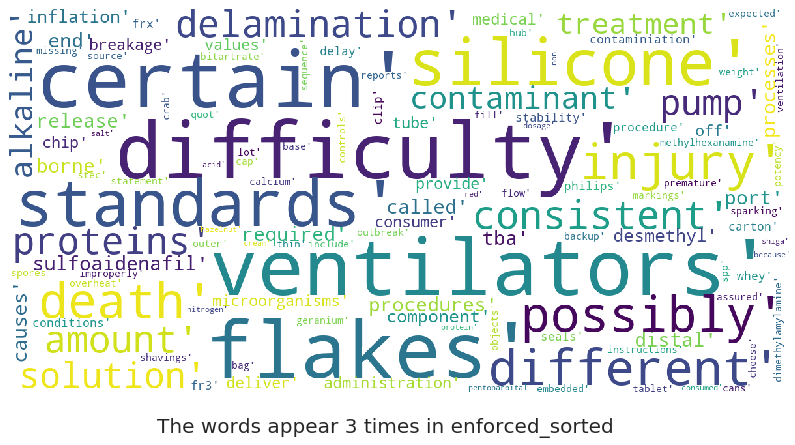

In [74]:
show_wordcloud(words_press_released_3, title = "The words appear 3 times in enforced_sorted")

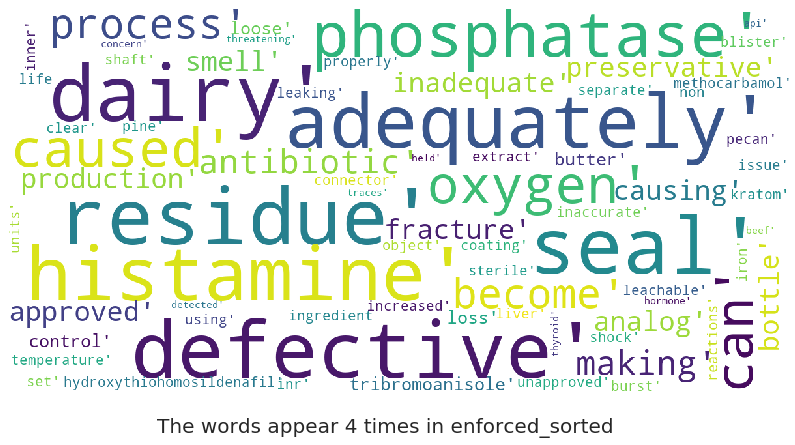

In [75]:
show_wordcloud(words_press_released_4, title = "The words appear 4 times in enforced_sorted")

Here, from count more than 4, the useless words ratio like "become" and "process" is small. (When we increase the minimum count like 10, we still have some useless words, so we analyzed compromise point to get useful health words.)

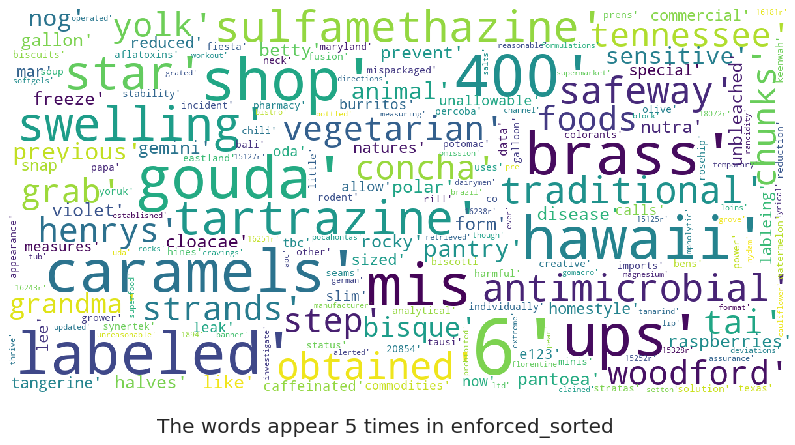

In [76]:
show_wordcloud(words_enforced_5, title = "The words appear 5 times in enforced_sorted")

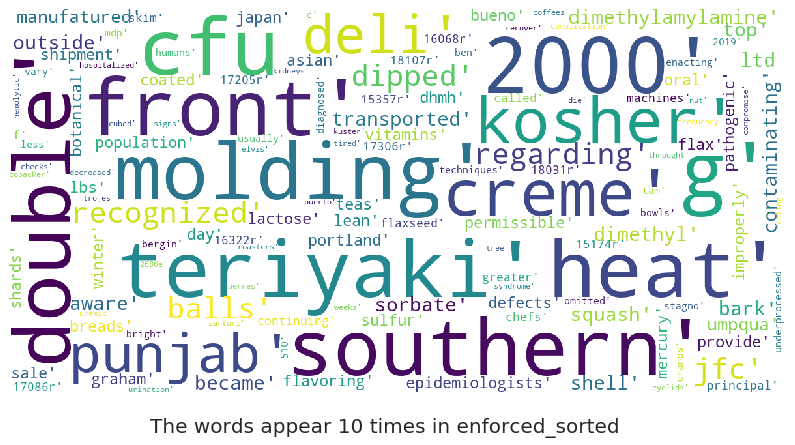

In [77]:
show_wordcloud(words_enforced_10, title = "The words appear 10 times in enforced_sorted")

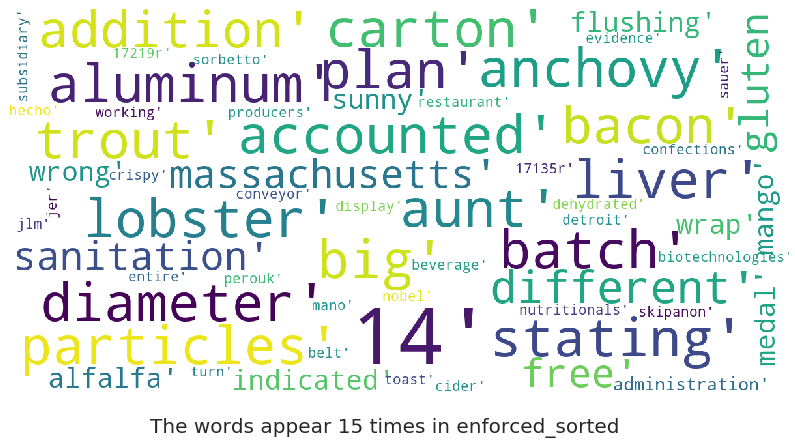

In [78]:
show_wordcloud(words_enforced_15, title = "The words appear 15 times in enforced_sorted")

Here, from count more than 15, the useless words ratio like "14" and "massachusetts" is small. (When we increase the minimum count like 20, we still have some useless words, so we analyzed compromise point to get useful health words.)

In [79]:
frequent_words_press_released = [word for word, count in press_released_sorted if count >= 4 if len(word)>2]
frequent_words_enforced = [word for word, count in enforced_sorted if count >= 30  if len(word)>2]

In [80]:
stemmed['FDA_press_released'] = stemmed['reviewStemmed'].apply(lambda x: [i for i in x if i in frequent_words_press_released])
stemmed['FDA_enforced'] = stemmed['reviewStemmed'].apply(lambda x: [i for i in x if i in frequent_words_enforced])

In [81]:
stemmed.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,reviewStemmed,afinnWords,afinnScores,afinnTotalScore,afinnWordsLen,afinnMeanScore,FDA_press_released,FDA_enforced
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,41,Not Frequent (1-50),"[ordered, spongbob, slippers, got, john, cena,...",[happy],[3],3.0,1,3.0,[],"[ordered, ordered]"
5,A3DTB6RVENLQ9Q,1453060375,Dont buy this item rip off at this price M...,1,2013-03-03,[[Grocery & Gourmet Food]],Mio,27,Not Frequent (1-50),"[dont, buy, item, rip, price, my, bad, mistake...","[bad, mistake, pay, pay]","[-3, -2, -1, -1]",-7.0,4,-2.0,[bottle],"[item, quantity, per, bottle]"
46,A3KJ9TZ2HLL7SA,5901002482,I wrote an earlier scathing review of this pro...,1,2012-11-28,[[Grocery & Gourmet Food]],NaN,85,Not Frequent (1-50),"[wrote, earlier, scathing, review, product, wh...","[harsh, apologize, disappointed, protect, hope...","[-2, -1, -2, 1, 2, -2]",-4.0,6,-1.0,"[product, product, problem]","[product, received, product, boxes, tea, boxes..."
48,ACEL2LY99MAB0,6162362183,I read the reviews before I bought it It got ...,2,2014-04-21,[[Grocery & Gourmet Food]],Nestle,67,Not Frequent (1-50),"[read, reviews, bought, it, got, excited, revi...","[excited, good, destroyed, mad, disappointed, ...","[3, 3, -3, -3, -2, 3]",1.0,6,0.0,"[package, package]","[good, package, crunch, two, package, made]"
61,A2F3CK8F9VIFPL,616719923X,I bought it because i like green tea but the t...,1,2013-07-29,[[Grocery & Gourmet Food]],NaN,27,Not Frequent (1-50),"[bought, like, green, tea, taste, bad, came, m...","[like, bad]","[2, -3]",-1.0,2,-0.0,[],"[green, tea, taste, came]"


In [82]:
l_stemmed_press_released = stemmed['FDA_press_released'].values.tolist()
l_stemmed_press_released = flatten(l_stemmed_press_released)

l_stemmed_enforced = stemmed['FDA_enforced'] .values.tolist()
l_stemmed_enforced = flatten(l_stemmed_enforced)

In [83]:
print(len(set(l_stemmed_press_released)))

278


In [84]:
print(len(set(l_stemmed_enforced)))

853


We categorized words that appeared in sentences explaining the reasons for FDA recall. To identify word categories, we used the following existing data sets.   
Especially for pathogens and diseases names, the existing datasets were too specialized (for doctors, hospitals, and related research institutions). However, in Amazon reviews, it is highly anticipated that most customers will use simpler words. Therefore, we aimed to eliminate these omissions by using data from websites containing general terms in addition to the technical term data set.

**Pathogen and disease words (e.g. salmonella)**
- EU safe food: https://www.safefood.eu/SafeFood/media/SafeFoodLibrary/Documents/Education/safefood%20for%20life/NI/section2_1.pdf
- Foodsafety.gov bacteria and viruses words: https://www.foodsafety.gov/food-poisoning/bacteria-and-viruses
- CDC foodborne illness words: https://www.cdc.gov/foodsafety/diseases/index.html
- CDC national outbreak reporting system: https://wwwn.cdc.gov/norsdashboard/  

**Symptom words (e.g. embolism)**
- EU safe food: https://www.safefood.eu/SafeFood/media/SafeFoodLibrary/Documents/Education/safefood%20for%20life/NI/section2_1.pdf
- Foodsafety.gov symptom words: https://www.foodsafety.gov/food-poisoning
- symptom dictionary: https://github.com/sekharvth/symptom-disease

**Food words (e.g. egg)**
- Exhaustive list of all foods & food items in the world: https://github.com/CurtisGrayeBabin/List-of-all-Foods

In [85]:
# # Import words datasets for categorizing

# # Import pathogen and disease words
# path_pathogen_EU = "../data/02_processed/pathogenic_bacteria.csv" # EU safe food
# path_pathogen_Foodsafety = "../data/02_processed/Foodsafety_gov_Bacteria_viruses.csv" # Foodsafety.gov bacteria and viruses words
# path_pathogen_CDC = "../data/02_processed/CDC_A-Z_Index_for_Foodborne_Illness.xlsx" # CDC foodborne illness words
# path_pathogen_CDC_outbreak = "../data/02_processed/NationalOutbreakPublicDataTool.xlsx" # CDC national outbreak reporting system

# # Import symptom words
# path_symptom_EU = "../data/02_processed/typical_symptoms.csv" # EU safe food
# path_symptom_Foodsafety = "../data/02_processed/Foodsafety_gov_symptom.csv" # # Foodsafety.gov symptom words
# path_symptom_github = "../data/02_processed/Dictionary.csv" # Symptom words from a github dataset

# # Import food words
# path_all_food = "../data/02_processed/FOOD.txt" # Exhaustive list of all foods & food items in the world

In [86]:
# Import words datasets for categorizing

# Import pathogen and disease words
path_pathogen_EU = "data/02_processed/pathogenic_bacteria.csv" # EU safe food
path_pathogen_Foodsafety = "data/02_processed/Foodsafety_gov_Bacteria_viruses.csv" # Foodsafety.gov bacteria and viruses words
path_pathogen_CDC = "data/02_processed/CDC_A-Z_Index_for_Foodborne_Illness.xlsx" # CDC foodborne illness words
path_pathogen_CDC_outbreak = "data/02_processed/NationalOutbreakPublicDataTool.xlsx" # CDC national outbreak reporting system

# Import symptom words
path_symptom_EU = "data/02_processed/typical_symptoms.csv" # EU safe food
path_symptom_Foodsafety = "data/02_processed/Foodsafety_gov_symptom.csv" # # Foodsafety.gov symptom words
path_symptom_github = "data/02_processed/Dictionary.csv" # Symptom words from a github dataset

# Import food words
path_all_food = "data/02_processed/FOOD.txt" # Exhaustive list of all foods & food items in the world

In [87]:
# Read pathogen and disease files
df_pathogen_EU = pd.read_csv(path_pathogen_EU, header=None, sep=';')
df_pathogen_Foodsafety = pd.read_csv(path_pathogen_Foodsafety, sep=';')
df_pathogen_CDC = pd.read_excel(path_pathogen_CDC, index_col=0)
df_pathogen_CDC_outbreak = pd.read_excel(path_pathogen_CDC_outbreak, index_col=0)

# Read symptom files
df_symptom_EU = pd.read_csv(path_symptom_EU, header=None, sep=";")
df_symptom_Foodsafety = pd.read_csv(path_symptom_Foodsafety, sep=';')
df_symptom_github = pd.read_csv(path_symptom_github, sep=',')

# Read food files
df_all_food = pd.read_table(path_all_food, header=None)

In [88]:
# Let's see the content of df_pathogen_EU as an example
df_pathogen_CDC_outbreak.head()

,Month,State,Primary Mode,Etiology,Serotype or Genotype,Etiology Status,Setting,Illnesses,Hospitalizations,Info on Hospitalizations,Deaths,Info on Deaths,Food Vehicle,Food Contaminated Ingredient,IFSAC Category,Water Exposure,Water Type,Animal Type,Animal Type Specify,Water Status
Year,,,,,,,,,,,,,,,,,,,,
2009,1,Minnesota,Person-to-person,Norovirus Genogroup II,unknown,Confirmed,Hotel/motel,21,0.0,19.0,0.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,1,Minnesota,Food,Norovirus,NaN,Suspected,Restaurant - Sit-down dining,2,0.0,2.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,2,Minnesota,Person-to-person,Norovirus,NaN,Suspected,"Other, specify",50,0.0,0.0,0.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,1,Minnesota,Person-to-person,Norovirus unknown,NaN,Confirmed,Restaurant,24,0.0,24.0,0.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,1,Minnesota,Food,Norovirus,NaN,Confirmed,NaN,16,0.0,8.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
# Stemmed all the dataframes

stemmed_pathogen_EU = df_pathogen_EU[0].astype(str).apply(lambda x : process_text(x))
stemmed_pathogen_Foodsafety = df_pathogen_Foodsafety['name'].astype(str).apply(lambda x : process_text(x))
stemmed_pathogen_CDC_outbreak = df_pathogen_CDC_outbreak['Etiology'].astype(str).apply(lambda x : process_text(x))

stemmed_symptom_EU = df_symptom_EU[0].astype(str).apply(lambda x : process_text(x))
stemmed_symptom_Foodsafety = df_symptom_Foodsafety['symptom names'].astype(str).apply(lambda x : process_text(x))
stemmed_symptom_github = df_symptom_github['Key'].astype(str).apply(lambda x : process_text(x))

stemmed_all_food = df_all_food[0].astype(str).apply(lambda x : process_text(x))

In [90]:
df_pathogen_CDC = df_pathogen_CDC[df_pathogen_CDC.index != 'ignore']
df_pathogen_CDC.head()

,name,disease,disease_2,pathogenesis,pathogenesis_2
category,,,,,
disease,Amebiasis,Amebiasis,NaN,NaN,NaN
disease,Anisakiasis,Anisakiasis,NaN,NaN,NaN
disease/pathogenesis,Ascariasis (Intestinal roundworm infection),Ascariasis,NaN,Intestinal roundworm,NaN
disease/pathogenesis,Angiostrongyliasis (Rat lungworm),Angiostrongyliasis,NaN,Rat lungworm,NaN
disease,Anthrax,Anthrax,NaN,NaN,NaN


In [91]:
# For df_pathogen_CDC, since we had to get information from multiple columns, we processed it separately.
df_pathogen_CDC = df_pathogen_CDC[df_pathogen_CDC.index != 'ignore']
df1 = df_pathogen_CDC['disease'].astype(str).apply(lambda x : process_text(x))
df2 = df_pathogen_CDC['disease_2'].astype(str).apply(lambda x : process_text(x))
df3 = df_pathogen_CDC['pathogenesis'].astype(str).apply(lambda x : process_text(x))
df4 = df_pathogen_CDC['pathogenesis_2'].astype(str).apply(lambda x : process_text(x))
stemmed_pathogen_CDC = pd.concat([df1, df2, df3, df4], axis=0)

In [92]:
# Concatenate these datasets for scoring reviews which will be done in other notebook
pathogen_words = pd.concat([stemmed_pathogen_EU.explode(), stemmed_pathogen_Foodsafety.explode(), 
                            stemmed_pathogen_CDC.explode()[stemmed_pathogen_CDC.explode() != 'nan'],
                            stemmed_pathogen_CDC_outbreak.explode()[stemmed_pathogen_CDC_outbreak.explode() != 'nan']], axis=0)
pathogen_words = pathogen_words[pathogen_words.duplicated() == False]
pathogen_words = pathogen_words[pathogen_words.apply(lambda x: len(x)) > 2]
pathogen_words = pathogen_words.reset_index()[0]
print(len(pathogen_words))

180


In [93]:
# Concatenate these datasets for scoring reviews which will be done in other notebook
symptom_words = pd.concat([stemmed_symptom_EU.explode(), stemmed_symptom_Foodsafety.explode(), 
                             stemmed_symptom_github.explode()], axis=0)
symptom_words = symptom_words[symptom_words.duplicated() == False]
symptom_words = symptom_words.reset_index()[0]
print(len(symptom_words))

319


In [94]:
pd.DataFrame(pathogen_words).to_csv('data/02_processed/pathogen_disease_dictionary.csv', index=False)
pd.DataFrame(symptom_words).to_csv('data/02_processed/symptom_dictionary.csv', index=False)

In [95]:
# Define a function that check whether the dataframe has words in recalled reasons

def check_words(words_lst, stemmed_df):
    result = []
    for word in words_lst:
        if stemmed_df.apply(lambda x: word in x).sum() > 0:
            result.append(word)
    return result

In [96]:
# Copy the press released words list
words_press_released_sorted_new = words_press_released_sorted.copy()

In [97]:
# Check whether the dataframe has words in recalled reasons

FDA_pathogen_EU_lst = check_words(words_press_released_sorted_new, stemmed_pathogen_EU)
FDA_pathogen_Foodsafety_lst = check_words(words_press_released_sorted_new, stemmed_pathogen_Foodsafety)
FDA_pathogen_CDC_lst = check_words(words_press_released_sorted_new, stemmed_pathogen_CDC)
FDA_pathogen_CDC_outbreak_lst = check_words(words_press_released_sorted_new, stemmed_pathogen_CDC_outbreak)
FDA_pathogen_disease_set = set(FDA_pathogen_EU_lst + FDA_pathogen_Foodsafety_lst + FDA_pathogen_CDC_lst + FDA_pathogen_CDC_outbreak_lst)

FDA_symptom_EU_lst = check_words(words_press_released_sorted_new, stemmed_symptom_EU)
FDA_symptom_Foodsafety_lst = check_words(words_press_released_sorted_new, stemmed_symptom_Foodsafety)
FDA_symptom_github_lst = check_words(words_press_released_sorted_new, stemmed_symptom_github)
FDA_symptom_set = set(FDA_symptom_EU_lst + FDA_symptom_Foodsafety_lst + FDA_symptom_github_lst)

FDA_all_food_lst = check_words(words_press_released_sorted_new, stemmed_all_food)
FDA_food_set = set(FDA_all_food_lst)

In [98]:
import random

In [99]:
# Let's see head of the pathogen and disease words list
random.sample(FDA_pathogen_disease_set, 10)

['histamine',
 'copper',
 'botulism',
 'enteritidis',
 '0157',
 'aeromonas',
 'monocytogenes',
 'botulinum',
 'pseudomonas',
 'causing']

In [100]:
# Let's see head of the symptom words list
random.sample(FDA_symptom_set, 10)

['positive',
 'sounds',
 'low',
 'cells',
 'chronic',
 'acute',
 'disease',
 'yellow',
 'embolism',
 'swallowing']

In [101]:
# Let's see head of the food words list
random.sample(FDA_food_set, 10)

['enteritidis',
 'strip',
 'requirement',
 'salt',
 'calcium',
 'pecan',
 'gel',
 'yellow',
 'patch',
 'oxide']

In [102]:
words_press_released_sorted_remained = set(words_press_released_sorted_new) - FDA_pathogen_disease_set - FDA_symptom_set - FDA_food_set

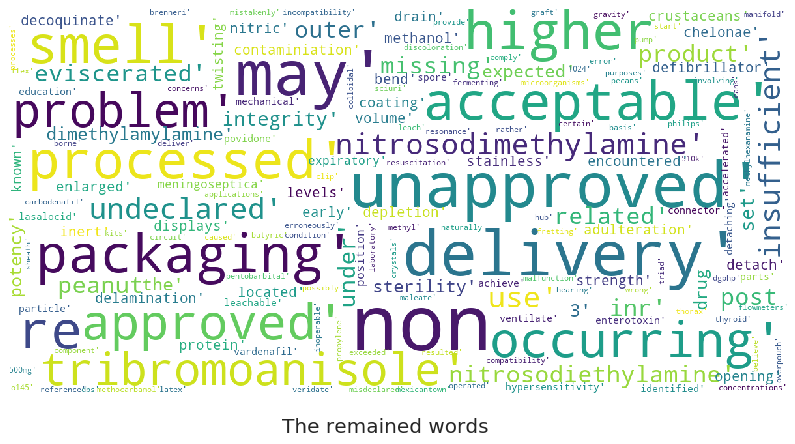

In [103]:
# tribromoanisole, nitrosodimethylamine should be in the bacteria list
show_wordcloud(list(words_press_released_sorted_remained), title = "The remained words")

In [104]:
# # Output all the categorized words lists to CSV files.
# pd.DataFrame(FDA_pathogen_disease_set).to_csv('../data/02_processed/FDA_pathogen_disease_words.csv', index=False)
# pd.DataFrame(FDA_symptom_set).to_csv('../data/02_processed/FDA_symptom_words.csv', index=False)
# pd.DataFrame(FDA_food_set).to_csv('../data/02_processed/FDA_food_words.csv', index=False)

In [105]:
# Output all the categorized words lists to CSV files.
pd.DataFrame(FDA_pathogen_disease_set).to_csv('data/02_processed/FDA_pathogen_disease_words.csv', index=False)
pd.DataFrame(FDA_symptom_set).to_csv('data/02_processed/FDA_symptom_words.csv', index=False)
pd.DataFrame(FDA_food_set).to_csv('data/02_processed/FDA_food_words.csv', index=False)

In [106]:
len(words_press_released_sorted_remained)

1149

## D Classification

Now that we have created some labelled data, we are now able to build a classifier to detect reviews that expose potential health threaths. This will serve as both a way to handle potentially new reviews, but also detect reviews that we probably missed earlier. 

Notice that we made a few assumptions during our label creation, which might not always hold. Notice also that our healthConcern category created in empath might not be exhaustive enough to capture all health-related issues. A classifier will help us solve those issues.

The classification will proceed in the following steps : 
* First, we start by processing the reviews (removing stopwords, stemming etc..) to have them in a standardized representation.
* Then, we will use **Word2vec** to transform the processed reviews into a numerical features spaces.
* Finally, we will train a **RandomForest** classifier using our labelled data, and use it to classify the rest of our reviews.

We start with the usual steps : reading in our data and removing column that we won't use to save memory space.

In [107]:
#empath = pd.read_pickle('drive/My Drive/empath')
empath = pd.read_pickle('empath')

empath.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,categories,brand,text_word_count,reviewer_freq,healthScore,danger
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,5,2013-10-11,[[Grocery & Gourmet Food]],NaN,88,Not Frequent (1-50),0.0,0.0
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,5,2012-12-06,[[Grocery & Gourmet Food]],NaN,119,Not Frequent (1-50),0.0,NaN
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,1,2013-12-02,[[Grocery & Gourmet Food]],NaN,41,Not Frequent (1-50),0.0,NaN
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,3,2011-06-12,[[Grocery & Gourmet Food]],NaN,60,Not Frequent (1-50),0.0,0.0
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,5,2012-03-24,[[Grocery & Gourmet Food]],NaN,66,Not Frequent (1-50),0.0,NaN


In [108]:
empath = empath.drop(labels=['unixReviewTime', 'categories', 'brand', 'overall'], axis=1)

empath.head()

,reviewerID,asin,reviewText,text_word_count,reviewer_freq,healthScore,danger
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,88,Not Frequent (1-50),0.0,0.0
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,119,Not Frequent (1-50),0.0,NaN
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,41,Not Frequent (1-50),0.0,NaN
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,60,Not Frequent (1-50),0.0,0.0
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,66,Not Frequent (1-50),0.0,NaN


We now process our reviews : 
* We first tokenize the sentences into words (not that this process is more sophisticated than simply separating words based on space).
* We then lowercase all tokens and remove those that we deem useless (those that contain only punctuation and the single characters tokens)
* Finally, we stem all the tokens.

In [109]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

stop_words = set(stopwords.words('english')) 

stemmer = PorterStemmer()

def process_text(sentence):
    token_words = nltk.word_tokenize(sentence)
    no_stopwords = [word.lower() for word in token_words if word not in stop_words and not \
                    all(c in string.punctuation for c in word) and not len(word) < 2]
    return [stemmer.stem(word) for word in no_stopwords]

print(process_text('I ordered spongbob slippers and I got John'))

['order', 'spongbob', 'slipper', 'got', 'john']


In [110]:
empath['tokenReviews'] = empath['reviewText'].apply(lambda x : process_text(x))

empath.head()

,reviewerID,asin,reviewText,text_word_count,reviewer_freq,healthScore,danger,tokenReviews
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,88,Not Frequent (1-50),0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ..."
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,119,Not Frequent (1-50),0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,41,Not Frequent (1-50),0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,60,Not Frequent (1-50),0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,66,Not Frequent (1-50),0.0,NaN,"[thi, product, archer, farm, best, drink, mix,..."


Now that we have processed our reviews, we will use **Word2Vec** to transform them into a numerical feature space that we will be able to use in our classification process.

The main reason to use Word2Vec for this step (instead of something like a simple BOW/TF-IDF scheme) was for its ability to capture context effectively and give similar representation to words with similar context. In our application, we want to be able to detect many differents possible threats which may be represented by different words, but will most likely share the same context. Thus, we needed a representation that focuses on that aspect. 

In [111]:
from gensim.models import Word2Vec

size=100

model = Word2Vec(empath['tokenReviews'].values, min_count=1, size=size)

print(model)

Word2Vec(vocab=172410, size=100, alpha=0.025)


Now that we have been able to associate a feature vector to each word, we will use a simple (yet effective) scheme to associate features vectors to complete reviews : simply take all the features vectors of its tokens, and average them.

In [112]:
def token_to_vectors(x):
    arr = []
    for word in x:
        if word in model.wv.vocab:
            arr.append(model.wv[word])
    if (len(arr) == 0):
        return np.zeros((size,))
    return np.array(arr).mean(axis=0)

print(token_to_vectors(['gmo', 'undisputed']))

[ 0.58236325 -1.3534786   1.6182463  -2.4781897   0.11623757  3.1542406
  1.2824295  -3.7907958   0.87270975  2.7563558   0.7632514  -2.9707878
 -2.071637   -3.0030901   1.698949    3.620799    1.5770879  -2.1920395
  1.3172222  -4.557101    0.61184937  4.7227383  -0.12930472  3.5929427
 -2.5105917  -3.2019644   1.8663632   3.2705984   0.71986985  2.8201983
  0.5549137  -0.38426423  3.281178   -3.3001232   2.9526818  -0.39040127
 -0.1221636  -2.1119177   3.190858    5.2511473   4.1830397   0.22096871
  2.7164943   2.9830701   3.3675327   0.9697776   1.9489001   0.35148656
  1.092539   -1.5940282   3.1514895  -4.788463   -0.27314195 -1.2021217
 -0.96227485 -1.4451058  -3.6540627   0.5721085   3.6488616   0.03938211
 -0.49760216  0.38853934  1.8992434   2.1056948  -2.23453     2.9398456
 -0.32587102  2.8570669   1.1997349  -4.6176944  -1.0158054  -1.7534022
 -2.0238001   0.1236677   2.4992526   2.1652055  -1.77447    -2.918686
 -1.6420559   0.590331    2.5723972  -0.96871835  0.10055557 

In [113]:
empath['feature'] = empath['tokenReviews'].apply(lambda x : token_to_vectors(x))

empath.head()

,reviewerID,asin,reviewText,text_word_count,reviewer_freq,healthScore,danger,tokenReviews,feature
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,88,Not Frequent (1-50),0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.8477476, 0.17251098, -0.029297449, 0.487644..."
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,119,Not Frequent (1-50),0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.31183714, 0.5197034, -0.5547906, 0.8308074,..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,41,Not Frequent (1-50),0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[-0.22456534, -0.16373743, 0.459948, 0.5711137..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,60,Not Frequent (1-50),0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.3684915, 0.024841074, -0.46019673, 0.486004..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,66,Not Frequent (1-50),0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.76114887, -0.36871892, -1.2590365, 0.762618..."


Now onto our classification process : we first start by creating our training set, which simply consists of all the reviews labelled in part C1.

In [114]:
train = empath[~empath['danger'].isna()]

train.head()

,reviewerID,asin,reviewText,text_word_count,reviewer_freq,healthScore,danger,tokenReviews,feature
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,88,Not Frequent (1-50),0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.8477476, 0.17251098, -0.029297449, 0.487644..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,60,Not Frequent (1-50),0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.3684915, 0.024841074, -0.46019673, 0.486004..."
6,A3LZA698SQPCXE,1453060464,My wife picked some of this up on sale I usu...,50,Not Frequent (1-50),0.0,0.0,"[my, wife, pick, sale, usual, drink, crystal, ...","[0.99000007, 0.05628058, -0.71792823, 0.825363..."
19,A2IPE2KFGTZMI3,3295000018,Fast and hot did I mention hot well its hot,10,Not Frequent (1-50),0.0,0.0,"[fast, hot, mention, hot, well, hot]","[0.54466325, 0.38352227, 0.7918902, 2.9630873,..."
23,A2H05FXY2BXUAN,3295000018,High quality worth every penny you pay for it...,34,Not Frequent (1-50),0.0,0.0,"[high, qualiti, worth, everi, penni, pay, the,...","[0.5843842, 0.21411626, 0.18608354, 0.5936703,..."


Then, we will split into an 90%-10% training/validation sets. Notice that for the splitting process, we use a **stratify** sampling strategy : to avoid having no reviews exposing health danger in either of the sets, we stratify on our danger column to make sure that each of the different values of that columns are proportionally equally represented.

In [115]:
from sklearn.model_selection import train_test_split

stratify_parameter = train.danger

X = np.array(train['feature'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, train['danger'].astype(int).values, \
                                                    test_size=0.1, random_state=10, \
                                                   stratify=stratify_parameter)

And finally, train our classifier on the training data : 

In [116]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100, random_state=10)
classifier.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

Once trained, we use our validation set to check the accuracy of our classifier, which yields a 88.5% accuracy :

In [117]:
from sklearn.metrics import accuracy_score

y_pred = classifier.predict(X_test)

print("Accuracy on validation set : {0:.3f}".format(accuracy_score(y_test, y_pred)))

Accuracy on validation set : 0.885


Finally, we create our test set using the reviews yet to be classified...

In [118]:
test = empath[empath['danger'].isna()]

test.head()

,reviewerID,asin,reviewText,text_word_count,reviewer_freq,healthScore,danger,tokenReviews,feature
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,119,Not Frequent (1-50),0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.31183714, 0.5197034, -0.5547906, 0.8308074,..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,41,Not Frequent (1-50),0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[-0.22456534, -0.16373743, 0.459948, 0.5711137..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,66,Not Frequent (1-50),0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.76114887, -0.36871892, -1.2590365, 0.762618..."
5,A3DTB6RVENLQ9Q,1453060375,Dont buy this item rip off at this price M...,27,Not Frequent (1-50),0.0,NaN,"[dont, buy, item, rip, price, my, bad, mistak,...","[1.7226131, -0.32579243, -0.33760604, 0.545222..."
7,A2XZPK86YY9R6G,1453060782,I bought these on sale for at my local ...,298,Not Frequent (1-50),0.0,NaN,"[bought, sale, local, supermarket, probabl, ov...","[0.7976564, -0.18401596, -0.54109347, 0.871140..."


...and use our classifier to classify those reviews :

In [119]:
X_testing_set = np.array(test['feature'].tolist())

test_pred = classifier.predict(X_testing_set)

In [120]:
test['danger'] = test_pred

test.head()

/home/embolo/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,reviewerID,asin,reviewText,text_word_count,reviewer_freq,healthScore,danger,tokenReviews,feature
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,119,Not Frequent (1-50),0.0,0,"[thi, absolut, undisput, favorit, tea, right, ...","[0.31183714, 0.5197034, -0.5547906, 0.8308074,..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,41,Not Frequent (1-50),0.0,0,"[order, spongbob, slipper, got, john, cena, ha...","[-0.22456534, -0.16373743, 0.459948, 0.5711137..."
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,66,Not Frequent (1-50),0.0,0,"[thi, product, archer, farm, best, drink, mix,...","[0.76114887, -0.36871892, -1.2590365, 0.762618..."
5,A3DTB6RVENLQ9Q,1453060375,Dont buy this item rip off at this price M...,27,Not Frequent (1-50),0.0,0,"[dont, buy, item, rip, price, my, bad, mistak,...","[1.7226131, -0.32579243, -0.33760604, 0.545222..."
7,A2XZPK86YY9R6G,1453060782,I bought these on sale for at my local ...,298,Not Frequent (1-50),0.0,0,"[bought, sale, local, supermarket, probabl, ov...","[0.7976564, -0.18401596, -0.54109347, 0.871140..."


Now that we have classified our test set, we will merge it back into our original dataframe :

In [121]:
final = pd.merge(empath, test, how='left', on=['reviewerID', 'asin'])

final.head()

,reviewerID,asin,reviewText_x,text_word_count_x,reviewer_freq_x,healthScore_x,danger_x,tokenReviews_x,feature_x,reviewText_y,text_word_count_y,reviewer_freq_y,healthScore_y,danger_y,tokenReviews_y,feature_y
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,88,Not Frequent (1-50),0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.8477476, 0.17251098, -0.029297449, 0.487644...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,119,Not Frequent (1-50),0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.31183714, 0.5197034, -0.5547906, 0.8308074,...",This is my absolute undisputed favorite tea r...,119.0,Not Frequent (1-50),0.0,0.0,"[thi, absolut, undisput, favorit, tea, right, ...","[0.31183714, 0.5197034, -0.5547906, 0.8308074,..."
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,41,Not Frequent (1-50),0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[-0.22456534, -0.16373743, 0.459948, 0.5711137...",I ordered spongbob slippers and I got John Cen...,41.0,Not Frequent (1-50),0.0,0.0,"[order, spongbob, slipper, got, john, cena, ha...","[-0.22456534, -0.16373743, 0.459948, 0.5711137..."
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,60,Not Frequent (1-50),0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.3684915, 0.024841074, -0.46019673, 0.486004...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,66,Not Frequent (1-50),0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.76114887, -0.36871892, -1.2590365, 0.762618...",This product by Archer Farms is the best drink...,66.0,Not Frequent (1-50),0.0,0.0,"[thi, product, archer, farm, best, drink, mix,...","[0.76114887, -0.36871892, -1.2590365, 0.762618..."


In [122]:
final = final.drop(['reviewText_y', 'healthScore_y', 'tokenReviews_y', 'feature_y'], axis=1)

final.head()

,reviewerID,asin,reviewText_x,text_word_count_x,reviewer_freq_x,healthScore_x,danger_x,tokenReviews_x,feature_x,text_word_count_y,reviewer_freq_y,danger_y
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,88,Not Frequent (1-50),0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.8477476, 0.17251098, -0.029297449, 0.487644...",NaN,NaN,NaN
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,119,Not Frequent (1-50),0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.31183714, 0.5197034, -0.5547906, 0.8308074,...",119.0,Not Frequent (1-50),0.0
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,41,Not Frequent (1-50),0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[-0.22456534, -0.16373743, 0.459948, 0.5711137...",41.0,Not Frequent (1-50),0.0
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,60,Not Frequent (1-50),0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.3684915, 0.024841074, -0.46019673, 0.486004...",NaN,NaN,NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,66,Not Frequent (1-50),0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.76114887, -0.36871892, -1.2590365, 0.762618...",66.0,Not Frequent (1-50),0.0


In [123]:
final = final.rename(columns={'reviewText_x': 'reviewText', 'healthScore_x': 'healthScore', 'danger_x': 'danger', 'tokenReviews_x': 'tokenReviews', 'feature_x': 'feature'})

final.head()

,reviewerID,asin,reviewText,text_word_count_x,reviewer_freq_x,healthScore,danger,tokenReviews,feature,text_word_count_y,reviewer_freq_y,danger_y
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,88,Not Frequent (1-50),0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.8477476, 0.17251098, -0.029297449, 0.487644...",NaN,NaN,NaN
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,119,Not Frequent (1-50),0.0,NaN,"[thi, absolut, undisput, favorit, tea, right, ...","[0.31183714, 0.5197034, -0.5547906, 0.8308074,...",119.0,Not Frequent (1-50),0.0
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,41,Not Frequent (1-50),0.0,NaN,"[order, spongbob, slipper, got, john, cena, ha...","[-0.22456534, -0.16373743, 0.459948, 0.5711137...",41.0,Not Frequent (1-50),0.0
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,60,Not Frequent (1-50),0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.3684915, 0.024841074, -0.46019673, 0.486004...",NaN,NaN,NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,66,Not Frequent (1-50),0.0,NaN,"[thi, product, archer, farm, best, drink, mix,...","[0.76114887, -0.36871892, -1.2590365, 0.762618...",66.0,Not Frequent (1-50),0.0


In [124]:
final['danger'] = np.where(final['danger'].isna(), final['danger_y'], final['danger'])

final.head()

,reviewerID,asin,reviewText,text_word_count_x,reviewer_freq_x,healthScore,danger,tokenReviews,feature,text_word_count_y,reviewer_freq_y,danger_y
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,88,Not Frequent (1-50),0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.8477476, 0.17251098, -0.029297449, 0.487644...",NaN,NaN,NaN
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,119,Not Frequent (1-50),0.0,0.0,"[thi, absolut, undisput, favorit, tea, right, ...","[0.31183714, 0.5197034, -0.5547906, 0.8308074,...",119.0,Not Frequent (1-50),0.0
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,41,Not Frequent (1-50),0.0,0.0,"[order, spongbob, slipper, got, john, cena, ha...","[-0.22456534, -0.16373743, 0.459948, 0.5711137...",41.0,Not Frequent (1-50),0.0
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,60,Not Frequent (1-50),0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.3684915, 0.024841074, -0.46019673, 0.486004...",NaN,NaN,NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,66,Not Frequent (1-50),0.0,0.0,"[thi, product, archer, farm, best, drink, mix,...","[0.76114887, -0.36871892, -1.2590365, 0.762618...",66.0,Not Frequent (1-50),0.0


In [125]:
final = final.drop('danger_y', axis=1)

final.head()

,reviewerID,asin,reviewText,text_word_count_x,reviewer_freq_x,healthScore,danger,tokenReviews,feature,text_word_count_y,reviewer_freq_y
0,A1ZQZ8RJS1XVTX,0657745316,No sugar no GMO garbage no fillers that come...,88,Not Frequent (1-50),0.0,0.0,"[no, sugar, gmo, garbag, filler, come, store, ...","[0.8477476, 0.17251098, -0.029297449, 0.487644...",NaN,NaN
1,A31W38VGZAUUM4,0700026444,This is my absolute undisputed favorite tea r...,119,Not Frequent (1-50),0.0,0.0,"[thi, absolut, undisput, favorit, tea, right, ...","[0.31183714, 0.5197034, -0.5547906, 0.8308074,...",119.0,Not Frequent (1-50)
2,A3I0AV0UJX5OH0,1403796890,I ordered spongbob slippers and I got John Cen...,41,Not Frequent (1-50),0.0,0.0,"[order, spongbob, slipper, got, john, cena, ha...","[-0.22456534, -0.16373743, 0.459948, 0.5711137...",41.0,Not Frequent (1-50)
3,A3QAAOLIXKV383,1403796890,The cart is fine and works for the purpose for...,60,Not Frequent (1-50),0.0,0.0,"[the, cart, fine, work, purpos, bought, farmer...","[0.3684915, 0.024841074, -0.46019673, 0.486004...",NaN,NaN
4,AB1A5EGHHVA9M,141278509X,This product by Archer Farms is the best drink...,66,Not Frequent (1-50),0.0,0.0,"[thi, product, archer, farm, best, drink, mix,...","[0.76114887, -0.36871892, -1.2590365, 0.762618...",66.0,Not Frequent (1-50)


Once our merging process is done, let's make sure that all our reviews are indeed classified : 

In [126]:
print("Does column 'danger' still contains nan values ? > {}".format(final['danger'].isna().any()))

Does column 'danger' still contains nan values ? > False


As a side note, notice that our merging process is only possible because the combination (reviewerID, asin) is an index of our dataframe, and thus there is a unique review for each combination of reviewer and product : 

In [127]:
empath.set_index(['reviewerID', 'asin']).index.is_unique

True

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef46a30e10>]],
      dtype=object)

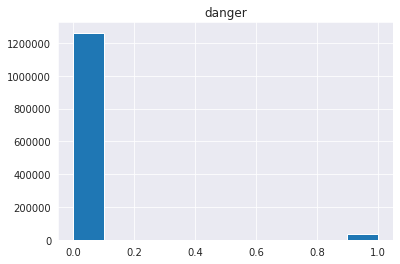

In [128]:
final['danger'] = final['danger'].astype(np.int8)
final.hist(column='danger')

We now have a quick look at the final result.

We see that we have a total of 34'270 reviews presenting health-related threats, which represents 2.64% of the total of reviews. Note that this is the kind of result we expected : only a small number of the reviews present such danger. 

Notice also that we initially labelled 20'253 reviews as health-threatening using empath, thus our classifier was able to find ~14'000 additional. 

In [129]:
threats = len(final[final['danger'] == 1])

print("Number of reviews presenting health threats : {}".format(threats))
print("Number of reviews : {}".format(len(final)))
print("Percentage : {0:.3f}%".format(threats*100/len(final)))

Number of reviews presenting health threats : 34270
Number of reviews : 1297156
Percentage : 2.642%


In [28]:
final[final['danger'] == 1].to_csv("data/02_processed/reviews_danger_true.csv")
final[final['danger'] == 0].to_csv("data/02_processed/reviews_danger_false.csv")

In [30]:
final.to_csv("data/02_processed/reviews_after_classification.csv")

# E Post Classification Analysis

In [3]:
final = pd.read_csv("data/02_processed/reviews_after_classification.csv")

Text(-0.12, 1200000, '1,263,256')

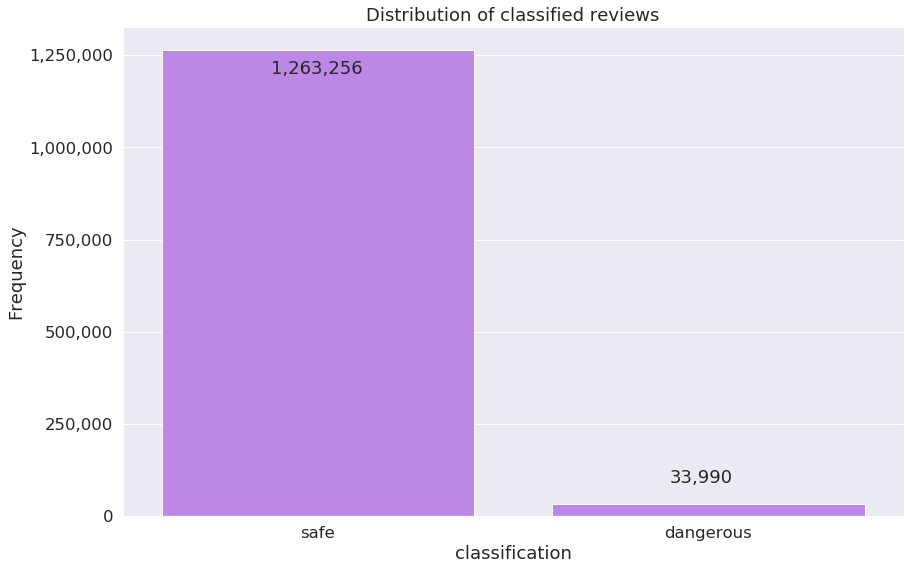

In [45]:
import seaborn as sns
light_purple = sns.xkcd_rgb["light purple"]
sns.set(font_scale=1.5,style="darkgrid")
plt.figure(figsize=(14,9))
sns.countplot(x="danger", data=final, color=light_purple)
plt.yticks(range(0,1250001,250000), ["0", "250,000", "500,000", "750,000", "1,000,000", "1,250,000"])
plt.xticks([0,1],["safe", "dangerous"])
plt.xlabel("classification")
plt.ylabel("Frequency")
plt.title("Distribution of classified reviews")
plt.annotate("33,990",(0.9,90000))
plt.annotate("1,263,256",(-0.12,1200000))

In [2]:
danger_reviews = pd.read_csv("data/02_processed/reviews_danger_true.csv")
safe_reviews = pd.read_csv("data/02_processed/reviews_danger_false.csv")

In [3]:
# load word list for symptoms and pathogens
pathogens = pd.read_csv('data/02_processed/pathogen_disease_dictionary.csv')
symptoms = pd.read_csv('data/02_processed/symptom_dictionary.csv')
food = pd.read_table('data/02_processed/FOOD.txt',header=None)

from pandas.core.common import flatten

symptoms = list(flatten(list(symptoms.values)))
pathogens = list(flatten(list(pathogens.values)))
food = list(flatten(list(food.values)))

In [4]:
import ast
danger_reviews_pathogens = danger_reviews[danger_reviews.tokenReviews.apply(lambda s: any(x in pathogens for x in ast.literal_eval(s)))]
danger_reviews_symptoms = danger_reviews[danger_reviews.tokenReviews.apply(lambda s: any(x in symptoms for x in ast.literal_eval(s)))]

danger_reviews_pathogens.to_csv("data/02_processed/danger_reviews_pathogens.csv")
danger_reviews_symptoms.to_csv("data/02_processed/danger_reviews_symptoms.csv")

In [5]:
food[:5]

['100 grand bar',
 '15 bean soup',
 '3 musketeers ',
 '50/50 burger',
 '98% cocoa stevia bar']

In [6]:
symptoms[:10]

['abdominal',
 'pain',
 'diarrhoea',
 'vomiting',
 'fever',
 'cramps',
 'low',
 'temperature',
 'difficulties',
 'breathing']

In [7]:
pathogens[:10]

['salmonella',
 'staphylococcus',
 'aureus',
 'clostridium',
 'perfringens',
 'botulinum',
 'botulism',
 'bacillus',
 'cereus',
 'campylobacter']

In [8]:
print("The 3 datasets contain {0} foods, {1} symptoms and {2} pathogens".format(len(food),len(symptoms),len(pathogens)))

The 3 datasets contain 21579 foods, 319 symptoms and 180 pathogens


We are now going to check how much they overlap with the processed text of our classified reviews.

In [9]:
# Define a function that check whether the dataframe has words in recalled reasons

def check_words(words_lst, stemmed_df):
    result = []
    for word in words_lst:
        if stemmed_df.apply(lambda x: word in x).sum() > 0:
            result.append(word)
    return result

In [72]:
check_words(pathogens, danger_reviews.tokenReviews)[:10]

['salmonella',
 'botulinum',
 'coli',
 'norovirus',
 'staph',
 'food',
 'poisoning',
 'diarrhea',
 'cholera',
 'illness']

In [73]:
check_words(pathogens, safe_reviews.tokenReviews)[:10]

['salmonella',
 'clostridium',
 'botulinum',
 'bacillus',
 'escherichia',
 'coli',
 'listeria',
 'staph',
 'food',
 'poisoning']

In [12]:
pathogens_in_danger_reviews = danger_reviews_pathogens.tokenReviews.apply(lambda x: [word for word in pathogens if word in x])

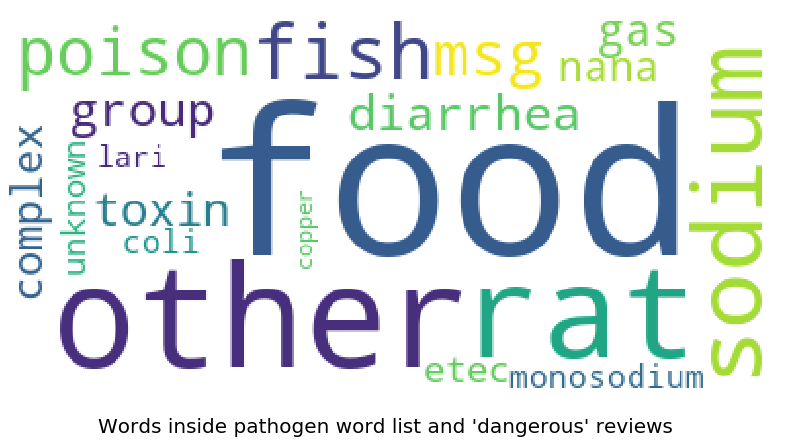

In [53]:
from collections import Counter
title = "Words inside pathogen word list and 'dangerous' reviews"
wordcloud = WordCloud(background_color="white",min_font_size=12)
wordcloud.generate_from_frequencies(frequencies = Counter(list(flatten(pathogens_in_danger_reviews))))
fig = plt.figure(1, figsize=(14, 9))
plt.axis('off')
fig.suptitle(title, fontsize=20)
fig.subplots_adjust(top=2.5)
plt.imshow(wordcloud)
plt.show()

In [50]:
symptoms_in_danger_reviews = danger_reviews_symptoms.tokenReviews.apply(lambda x: [word for word in pathogens if word in x])

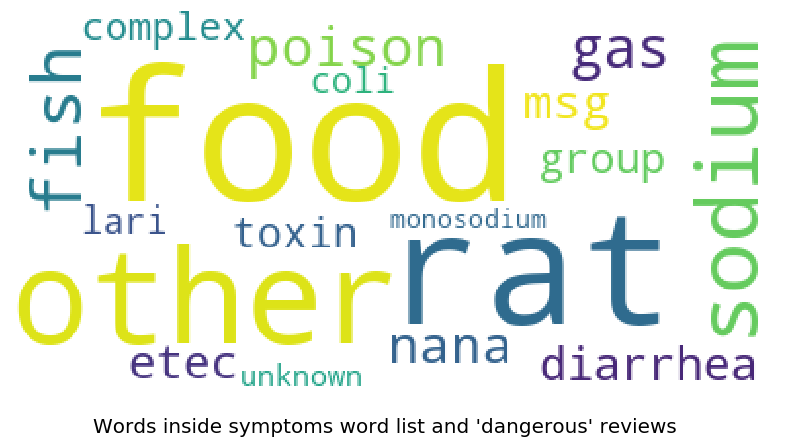

In [52]:
title = "Words inside symptoms word list and 'dangerous' reviews"
wordcloud = WordCloud(background_color="white",min_font_size=12)
wordcloud.generate_from_frequencies(frequencies = Counter(list(flatten(symptoms_in_danger_reviews))))
fig = plt.figure(1, figsize=(14, 9))
plt.axis('off')
fig.suptitle(title, fontsize=20)
fig.subplots_adjust(top=2.5)
plt.imshow(wordcloud)
plt.show()

In [56]:
food_in_danger_reviews = danger_reviews.tokenReviews.apply(lambda x: [word for word in food if word in x])

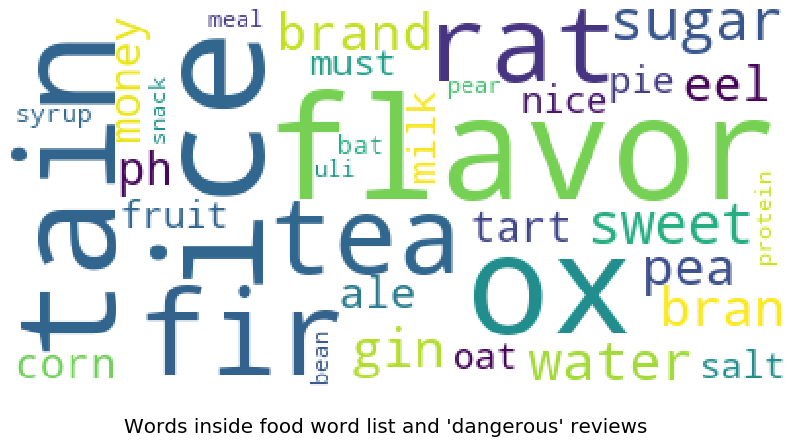

In [57]:
title = "Words inside food word list and 'dangerous' reviews"
wordcloud = WordCloud(background_color="white",min_font_size=12)
wordcloud.generate_from_frequencies(frequencies = Counter(list(flatten(food_in_danger_reviews))))
fig = plt.figure(1, figsize=(14, 9))
plt.axis('off')
fig.suptitle(title, fontsize=20)
fig.subplots_adjust(top=2.5)
plt.imshow(wordcloud)
plt.show()

In [ ]:
food_in_safe_reviews = safe_reviews.tokenReviews.apply(lambda x: [word for word in food if word in x])

In [ ]:
title = "Words inside food word list and 'safe' reviews"
wordcloud = WordCloud(background_color="white",min_font_size=12)
wordcloud.generate_from_frequencies(frequencies = Counter(list(flatten(food_in_safe_reviews))))
fig = plt.figure(1, figsize=(14, 9))
plt.axis('off')
fig.suptitle(title, fontsize=20)
fig.subplots_adjust(top=2.5)
plt.imshow(wordcloud)
plt.show()